# Telecom Churn Case Study

### The code is divided into the following sections:

1. Data Understanding
2. Data Cleaning and Manipulation ( Missing Value Treatment, Outlier Treatment etc. )
3. Exploratory Data Analysis ( Univariate, Segmented Univariate, Bivariate, Derived Metrics )
4. Model Creation- Preparing the Dataset and Oversampling using SMOTE
5. Models- Prediction Models
6. Models- Driver Variables Models
7. Recommendations

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB


pd.set_option('display.max_colwidth', -1)

data = pd.read_csv("telecom_churn_data.csv")

data.info()

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


## 1. Data Understanding

In [2]:
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


The dataset has 226 variables including the variable churn which we would eventually model for, using the remaining variables and their derivatives

Each of the variables are populated for 4 months- June, July, Aug, Sept

where June and July are classified as the 'Good' Months
      August is classified as the 'Action' month
      Sept is classified as the 'churn' month
      
Using the data for June, July and August we need to predict churn ( that will happen in Sept )      

With the help of the data dictionary, we can see that the kinds of information that are available to us for using as independent variables, directly or as a derivative of the existing data, are the following: 



1. Call info- Minutes of Usage- Divided into Outgoing / Incoming, Type of operator, Roaming/Not Roaming, Local / STD, Special, ISD and so on.
2. ARPU- Average Revenue per User 
3. Recharge- Data, Amount
4. Age on Network
5. Scheme related info- FB User, Night Pack

## 2. Data Cleaning and Manipulation

In [3]:
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
# Removing rows and columns which have all null values
data.dropna(axis = 1, how = 'all', inplace = True)
data.dropna(how='all', inplace=True)
data.shape

(99999, 226)

### Missing Value Treatment- 1

Check if the missing value for data columns per month are missing for the same rows.

There are 10 data related columns. So for a given row, if all the data related columns are NA (including the last date of recharge data) for a given month, then the corresponding columns can be imputed with 0 (for numeric columns) and -1 for binary categorical columns.

In [5]:
data[['total_rech_data_6','av_rech_amt_data_6','max_rech_data_6','count_rech_2g_6','count_rech_3g_6','night_pck_user_6','arpu_3g_6','arpu_2g_6','fb_user_6','date_of_last_rech_data_6']].isnull().sum()

total_rech_data_6           74846
av_rech_amt_data_6          74846
max_rech_data_6             74846
count_rech_2g_6             74846
count_rech_3g_6             74846
night_pck_user_6            74846
arpu_3g_6                   74846
arpu_2g_6                   74846
fb_user_6                   74846
date_of_last_rech_data_6    74846
dtype: int64

In [6]:
data[(data[['total_rech_data_6','av_rech_amt_data_6','max_rech_data_6','count_rech_2g_6','count_rech_3g_6','night_pck_user_6','arpu_3g_6','arpu_2g_6','fb_user_6','date_of_last_rech_data_6']].isnull().sum(axis=1) == 10)].shape

(74846, 226)

In [7]:
data[['total_rech_data_7','av_rech_amt_data_7','max_rech_data_7','count_rech_2g_7','count_rech_3g_7','night_pck_user_7','arpu_3g_7','arpu_2g_7','fb_user_7','date_of_last_rech_data_7']].isnull().sum()

total_rech_data_7           74428
av_rech_amt_data_7          74428
max_rech_data_7             74428
count_rech_2g_7             74428
count_rech_3g_7             74428
night_pck_user_7            74428
arpu_3g_7                   74428
arpu_2g_7                   74428
fb_user_7                   74428
date_of_last_rech_data_7    74428
dtype: int64

In [8]:
data[(data[['total_rech_data_7','av_rech_amt_data_7','max_rech_data_7','count_rech_2g_7','count_rech_3g_7','night_pck_user_7','arpu_3g_7','arpu_2g_7','fb_user_7','date_of_last_rech_data_7']].isnull().sum(axis=1) == 10)].shape

(74428, 226)

In [9]:
data[['total_rech_data_8','av_rech_amt_data_8','max_rech_data_8','count_rech_2g_8','count_rech_3g_8','night_pck_user_8','arpu_3g_8','arpu_2g_8','fb_user_8','date_of_last_rech_data_8']].isnull().sum()

total_rech_data_8           73660
av_rech_amt_data_8          73660
max_rech_data_8             73660
count_rech_2g_8             73660
count_rech_3g_8             73660
night_pck_user_8            73660
arpu_3g_8                   73660
arpu_2g_8                   73660
fb_user_8                   73660
date_of_last_rech_data_8    73660
dtype: int64

In [10]:
data[(data[['total_rech_data_8','av_rech_amt_data_8','max_rech_data_8','count_rech_2g_8','count_rech_3g_8','night_pck_user_8','arpu_3g_8','arpu_2g_8','fb_user_8','date_of_last_rech_data_8']].isnull().sum(axis=1) == 10)].shape

(73660, 226)

In [11]:
data[['total_rech_data_9','av_rech_amt_data_9','max_rech_data_9','count_rech_2g_9','count_rech_3g_9','night_pck_user_9','arpu_3g_9','arpu_2g_9','fb_user_9','date_of_last_rech_data_9']].isnull().sum()

total_rech_data_9           74077
av_rech_amt_data_9          74077
max_rech_data_9             74077
count_rech_2g_9             74077
count_rech_3g_9             74077
night_pck_user_9            74077
arpu_3g_9                   74077
arpu_2g_9                   74077
fb_user_9                   74077
date_of_last_rech_data_9    74077
dtype: int64

In [12]:
data[(data[['total_rech_data_9','av_rech_amt_data_9','max_rech_data_9','count_rech_2g_9','count_rech_3g_9','night_pck_user_9','arpu_3g_9','arpu_2g_9','fb_user_9','date_of_last_rech_data_9']].isnull().sum(axis=1) == 10)].shape

(74077, 226)

Now that we have confirmed that if date of last recharge data is NAN, all other related columns are also NaN, impute those cells.

In [13]:
data.update(data[['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9']].fillna(0))
data.update(data[['av_rech_amt_data_6','av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']].fillna(0))
data.update(data[['max_rech_data_6','max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9']].fillna(0))
data.update(data[['count_rech_2g_6','count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9']].fillna(0))
data.update(data[['count_rech_3g_6','count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9']].fillna(0))
data.update(data[['night_pck_user_6','night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9']].fillna(0))
data.update(data[['arpu_3g_6','arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9']].fillna(0))
data.update(data[['arpu_2g_6','arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9']].fillna(0))
data.update(data[['fb_user_6','fb_user_7', 'fb_user_8', 'fb_user_9']].fillna(0))

Can we now impute the NaN in _mou columns?

We see that mou columns per month are split across various type of calls like t2t, t2m, etc and there is a corresponding total mou column. So, for a give customer, if the total mou in a given month is zero, then we can safely impute the sub-category calls in that month for that customer to 0.

In [14]:
def impute_mou(df, type):
    """
    Method that takes in the dataframe and the type of call ('ic' for incoming and 'og for outgoing')
    a) For each month we construct a list of sub-category mou columns (t2t, t2m, etc) of the user given type.
    b) Construct the column name that gives the total mou for that month and type (eg:total_og_mou_6)
    c) Check if there are any rows where any of the sub-category mou values is NaN but the 'total' value for that row is non-zero.
    d) If there are no such rows, then safely impute the sub-category column NaNs with 0 for that month.
    @Author- SS
    """
    for m in ['6','7','8','9']:
        mou_cols = [c for c in df.columns if ((c[-5:] == 'mou_' + m) & (type in c))]
        mou_cols.append('onnet_mou_' + m)
        mou_cols.append('offnet_mou_' + m)       
        mou_cols.append(type + '_others_' + m) 
        total_col = 'total_' + type + '_mou_' + m
        if (df[((df[mou_cols].isnull().any(axis = 1)) & (df[total_col]!=0))].mobile_number.count() == 0):
            df.update(data[mou_cols].fillna(0))

In [15]:
impute_mou(data, 'og')
impute_mou(data, 'ic')

In [16]:
data.isnull().sum()

mobile_number           0   
circle_id               0   
loc_og_t2o_mou          1018
std_og_t2o_mou          1018
loc_ic_t2o_mou          1018
last_date_of_month_6    0   
last_date_of_month_7    601 
last_date_of_month_8    1100
last_date_of_month_9    1659
arpu_6                  0   
arpu_7                  0   
arpu_8                  0   
arpu_9                  0   
onnet_mou_6             0   
onnet_mou_7             0   
onnet_mou_8             0   
onnet_mou_9             0   
offnet_mou_6            0   
offnet_mou_7            0   
offnet_mou_8            0   
offnet_mou_9            0   
roam_ic_mou_6           0   
roam_ic_mou_7           0   
roam_ic_mou_8           0   
roam_ic_mou_9           0   
roam_og_mou_6           0   
roam_og_mou_7           0   
roam_og_mou_8           0   
roam_og_mou_9           0   
loc_og_t2t_mou_6        0   
                       ..   
arpu_2g_9               0   
night_pck_user_6        0   
night_pck_user_7        0   
night_pck_user

Now, can we impute the NaN in loc_og_t2o_mou, loc_ic_t2o_mou and std_og_t2o_mou?

Again it is safe to impute them as 0 IF the 'total' mou for those customers is zero.

There are 1018 observations where the above columns are NaNs. Check how many of them have 'total' mou as 0.

In [17]:
#Check the number of observations where:
# a) any loc_og_t2o_mou, loc_ic_t2o_mou and std_og_t2o_mou is NaN  AND
# b) Sum of total mou fo all types and months for that observation is zero.
data[((data[['loc_og_t2o_mou','loc_ic_t2o_mou','std_og_t2o_mou']].isnull().any(axis = 1)) & (data['total_ic_mou_6']==0) & (data['total_ic_mou_7']==0) & (data['total_ic_mou_8']==0) & (data['total_ic_mou_9']==0) & (data['total_og_mou_6']==0) & (data['total_og_mou_7']==0) & (data['total_og_mou_8']==0) & (data['total_og_mou_9']==0))].mobile_number.count()

1018

There is an exact match. So we can impute those NaNs also with 0

In [18]:
data.update(data[['loc_og_t2o_mou','loc_ic_t2o_mou','std_og_t2o_mou']].fillna(0))

In [19]:
data.isnull().sum()

mobile_number           0   
circle_id               0   
loc_og_t2o_mou          0   
std_og_t2o_mou          0   
loc_ic_t2o_mou          0   
last_date_of_month_6    0   
last_date_of_month_7    601 
last_date_of_month_8    1100
last_date_of_month_9    1659
arpu_6                  0   
arpu_7                  0   
arpu_8                  0   
arpu_9                  0   
onnet_mou_6             0   
onnet_mou_7             0   
onnet_mou_8             0   
onnet_mou_9             0   
offnet_mou_6            0   
offnet_mou_7            0   
offnet_mou_8            0   
offnet_mou_9            0   
roam_ic_mou_6           0   
roam_ic_mou_7           0   
roam_ic_mou_8           0   
roam_ic_mou_9           0   
roam_og_mou_6           0   
roam_og_mou_7           0   
roam_og_mou_8           0   
roam_og_mou_9           0   
loc_og_t2t_mou_6        0   
                       ..   
arpu_2g_9               0   
night_pck_user_6        0   
night_pck_user_7        0   
night_pck_user

In [20]:
CAT = 'categorical'
NUM = 'numerical'

def get_col_type(col):
    cols = data.columns
    num_cols = data._get_numeric_data().columns
    if(col in num_cols):
        if('night_pck'==col[0:9] or 'fb_user'==col[0:7] or 'sachet' == col[0:6]):
            return CAT
        else:
            return NUM
    else:
        return CAT

def generate_null_dataframe(data):
    null_df = pd.DataFrame(data.isnull().sum()*100/len(data), columns=['na_perc'])
    null_df['column'] = null_df.index
    null_df.index = range(0,len(null_df['column']))
    null_df['col_type'] = null_df['column'].map(get_col_type)
    null_df = null_df[null_df.na_perc > 0]
    return null_df

def impute_cols_perc(null_df, data, perc):
    ndf = null_df.copy()
    ndf = ndf[ndf.na_perc > perc] 
    for index, row in ndf.iterrows():
        colname = row['column']
        if(CAT == row['col_type'] and 'date' != colname[0:4]):
            data[colname] = data[colname].fillna(-1)
        else:
            data[colname] = data[colname].fillna(0)

def impute_with_mode(data, cols):
    for column in cols:
        data[column].fillna(data[column].mode()[0], inplace=True)

**Imputing rest of the NA data**

In [21]:
cols = [c for c in data.columns if c[0:18] == 'last_date_of_month']
impute_with_mode(data, cols)
null_df = generate_null_dataframe(data)
null_df

,na_perc,column,col_type
149,1.607016,date_of_last_rech_6,categorical
150,1.767018,date_of_last_rech_7,categorical
151,3.622036,date_of_last_rech_8,categorical
152,4.760048,date_of_last_rech_9,categorical
157,74.846748,date_of_last_rech_data_6,categorical
158,74.428744,date_of_last_rech_data_7,categorical
159,73.660737,date_of_last_rech_data_8,categorical
160,74.077741,date_of_last_rech_data_9,categorical


Date of last recharge data has more than 70 percent missing values so dropping these 4 columns as imputing them would create a lot of bias.

In [22]:
data.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8', 'date_of_last_rech_data_9'], axis=1, inplace=True)

In [23]:
# Let's check the null columns now
null_df = generate_null_dataframe(data)
null_df

,na_perc,column,col_type
149,1.607016,date_of_last_rech_6,categorical
150,1.767018,date_of_last_rech_7,categorical
151,3.622036,date_of_last_rech_8,categorical
152,4.760048,date_of_last_rech_9,categorical


**There are 4 more columns pertaining to date that have NA values. These will be imputed using KNN imputations after the high valued customers are identified.**

#### Rename columns with confusing names

In [24]:
data = data.rename(columns={'aug_vbc_3g': 'vbc_3g_8', 'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'sep_vbc_3g': 'vbc_3g_9'})

### Calculating the churn and non-churn values

In [25]:
# Calculating average recharge for 6th and 7th month

data['total_rech_6'] = (data['av_rech_amt_data_6']*data['total_rech_data_6']) + data['total_rech_amt_6']
data['total_rech_7'] = (data['av_rech_amt_data_7']*data['total_rech_data_7']) + data['total_rech_amt_7']
data['total_rech_8'] = (data['av_rech_amt_data_8']*data['total_rech_data_8']) + data['total_rech_amt_8']
data['avg_rech_amt_6_7'] = (data['total_rech_6'] + data['total_rech_7'])/2

In [26]:
#70th percentile of average recharge.
perct_70 = data['avg_rech_amt_6_7'].quantile(0.7)
perct_70

478.0

In [27]:
#High Value Customer.
data = data[data['avg_rech_amt_6_7'] >= perct_70]
data.shape

(30001, 226)

In [28]:
#Deciding Churn Value
def churn(row):
    if ((row['total_ic_mou_9'] == 0) & (row['total_og_mou_9'] == 0) & (row['vol_2g_mb_9'] == 0) & (row['vol_3g_mb_9'] == 0)):
        return 1
    else:
        return 0

In [29]:
data['churn'] = data.apply(churn, axis=1)

In [30]:
data.groupby('churn')['churn'].count()

churn
0    27560
1    2441 
Name: churn, dtype: int64

In [31]:
data.groupby('churn')['churn'].count()/data['churn'].count()

churn
0    0.918636
1    0.081364
Name: churn, dtype: float64

In [32]:
#removing all columns with month _9 data
cols = [c for c in data.columns if c[-2:] != '_9']
data = data[cols]
data.shape

(30001, 173)

In [33]:
#Also we can remove the below columns; Reason : No variance
data = data.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'], axis=1)
data.shape

(30001, 160)

### Missing Value Treatment- 2

Imputing missing date columns

We will be converting rest of the date colummns to delta of days schich represents number of days elapsed between the last recharge done by customer and first day of 6th month i.e. June 1, 2014.

In [34]:
# Let's check the null columns now
null_df = generate_null_dataframe(data)
null_df

,na_perc,column,col_type
100,0.243325,date_of_last_rech_6,categorical
101,0.326656,date_of_last_rech_7,categorical
102,1.943269,date_of_last_rech_8,categorical


In [35]:
data['date_of_last_rech_6'] =  pd.to_datetime(data['date_of_last_rech_6'])
data['date_of_last_rech_7'] =  pd.to_datetime(data['date_of_last_rech_7'])
data['date_of_last_rech_8'] =  pd.to_datetime(data['date_of_last_rech_8'])

We impute the missing date deltas with 90 days as according to the business use case it constitutes that the person has not recharged for the longest time.

In [36]:
from datetime import datetime
import math
def convert_to_date_delta(d):
    start_date = datetime(2014,6,1)
    delta = (d-start_date).days
    return 90.0 if math.isnan(delta) else delta

In [37]:
data['delta_date_last_rech_6'] = data['date_of_last_rech_6'].apply(lambda d: convert_to_date_delta(d))
data['delta_date_last_rech_7'] = data['date_of_last_rech_7'].apply(lambda d: convert_to_date_delta(d))
data['delta_date_last_rech_8'] = data['date_of_last_rech_8'].apply(lambda d: convert_to_date_delta(d))

In [38]:
# Dropping the date columns now
data.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1, inplace=True)

In [39]:
# Let's check the null columns now
null_df = generate_null_dataframe(data)
null_df

,na_perc,column,col_type


In [40]:
del null_df

### Outlier Treatment

In [41]:
# Removing Outliers 
# if there are 20 columns in a row that have values 3 times more than the IQR then we drop the row.

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~(((data < (Q1 - (3 * IQR))) |(data > (Q3 + (3 * IQR)))).sum(axis=1) > 20)]
data.shape

(25323, 160)

### Average and ratio column creation

#### Before modelling, in the interest of limiting the number of features, let us look at the data in terms of phases ('good' and 'action') as against in terms of months (6, 7, 8). So we will consolidate the data for months 6 and 7 into a single '_avg_6_7' column.

In [42]:
# For each of the numeric columns, create a new '_avg_6_7' columns which is simply
# the average of values in _6 and _7 columns for each type of metric for each observation
def create_avg_and_ratio_cols(data, numeric_cols):
    for c in numeric_cols:
        col_6 = c + '_6'
        col_7 = c + '_7'
        col_8 = c + '_8'
        avg_col = c + '_avg_6_7'
        ratio_col = c +'_ratio_8_to_avg_6_7'
        # Calculate average of month 6 and 7.
        data[avg_col] = (data[col_6] + data[col_7]) / 2
        
        # As we are going to calculate ratio, make sure there are no 'zero'
        # values in numerator or denominator. Incrementing the values by
        # 1 is not going to change the business interpretation of the mou
        # or recharge amount metrics.
        data[col_8] = data[col_8].replace({0 : 1})
        data[avg_col] = data[avg_col].replace({0 : 1})
        data[ratio_col] = data[col_8] / data[avg_col]
        data.drop([col_6, col_7], axis = 1, inplace = True)

In [43]:
# Make a list of the numberic columns (consider one month, get rid of the month number and exclude the category columns)
numeric_cols = [c.split('_6')[0] for c in data.columns if ((c[-2:] == '_6') & ~('fb' in c) & ~('sachet' in c) & ~('date' in c) & ~('night' in c))]

In [44]:
create_avg_and_ratio_cols(data, numeric_cols)

# 3. Exploratory Data Analysis

Segmenting data into churn and non-churn for segmented univariate analysis

In [45]:
data_churn = data[data['churn'] == 1]
data_nochurn = data[data['churn'] == 0]

Look at the statistics of a few metrics (recharge amount, total outgoing usage, etc) and compare them across months 7 and 8 ('good' and 'action')

In [46]:
data_churn.total_og_mou_8.describe()

count    2234.000000
mean     177.237757 
std      406.532498 
min      0.030000   
25%      1.000000   
50%      1.000000   
75%      150.577500 
max      4259.010000
Name: total_og_mou_8, dtype: float64

In [47]:
data_nochurn.total_og_mou_8.describe()

count    23089.000000
mean     535.781946  
std      622.156264  
min      0.010000    
25%      88.330000   
50%      344.190000  
75%      770.260000  
max      14043.060000
Name: total_og_mou_8, dtype: float64

In [48]:
data_churn.total_og_mou_avg_6_7.describe()

count    2234.000000
mean     672.533944 
std      680.982081 
min      0.015000   
25%      92.412500  
50%      520.977500 
75%      1019.080000
max      5672.455000
Name: total_og_mou_avg_6_7, dtype: float64

In [49]:
data_nochurn.total_og_mou_avg_6_7.describe()

count    23089.000000
mean     572.894422  
std      563.390397  
min      0.005000    
25%      131.345000  
50%      437.255000  
75%      847.415000  
max      6278.760000 
Name: total_og_mou_avg_6_7, dtype: float64

#### Inference:
##### Looking at only the action period, churned customers have used the network way less in the non-churned customers (eg: total_og_mou_8 median is 0 for churned and 367 for non-churned.

##### Secondly, churned customers have used the network way less in the 'action' period than in the 'good' period. There is not that big a difference for non churned customers across those 2 periods. (eg: median for total_og_mou_8 and total_og_mou_7 are 336 and 0 respectively for CHURNED customers. The corresponding numbers are 367 and 431 for non-churned customers.

### SEGMENTED UNIVARIATE (CHURN v/s NON CHURN) across average of months 6, 7 and 8

In [50]:
def compare_churn_nonchurn(var_l):
    for var in var_l:
        suffix_str_l = ['_avg_6_7','_8']
        var_suffix_l = [var + x for x in suffix_str_l]
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        sb.barplot(data=data_churn[var_suffix_l])
        plt.title("CHURN")

        plt.subplot(1, 2, 2)
        sb.barplot(data=data_nochurn[var_suffix_l])
        plt.title("NO CHURN")

In [51]:
num_variables = list(set(numeric_cols))
print(len(num_variables))

47


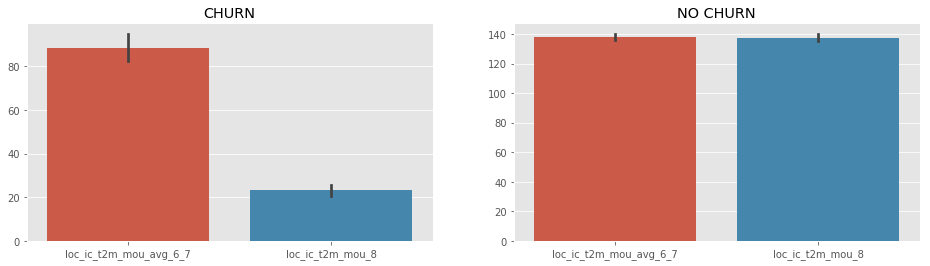

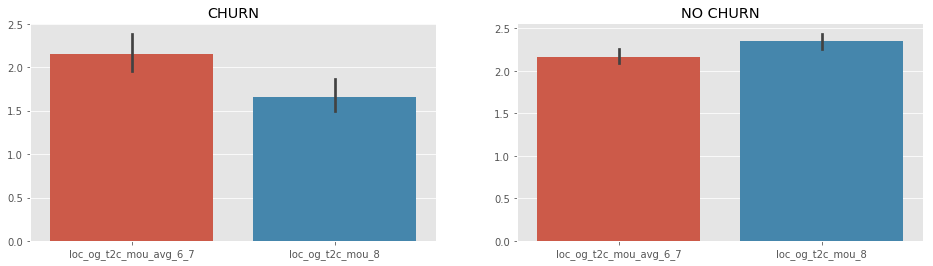

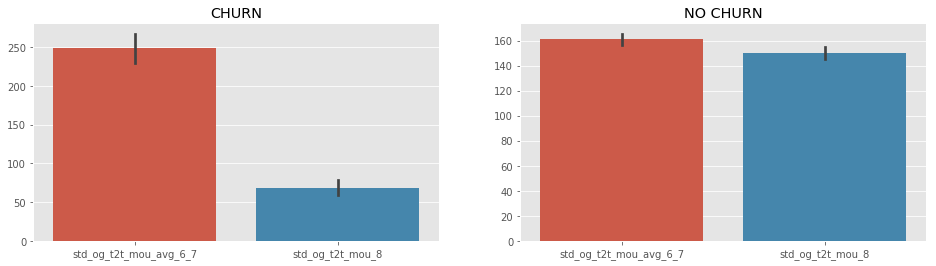

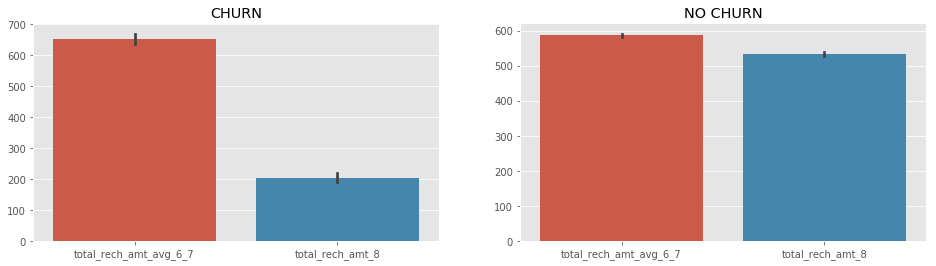

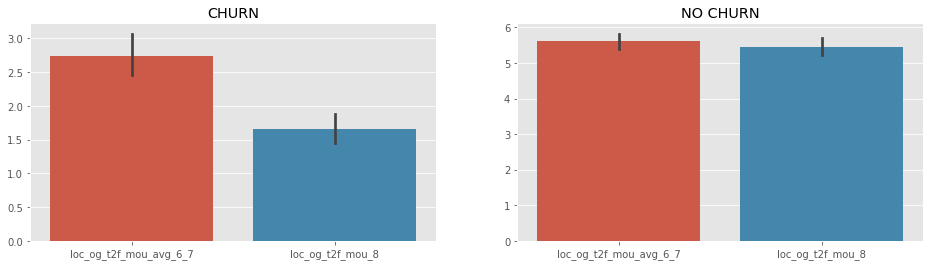

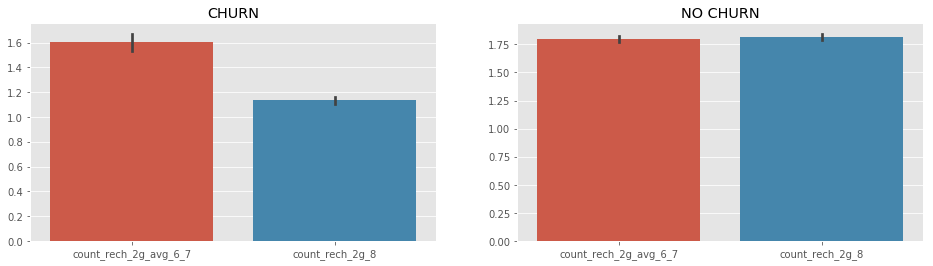

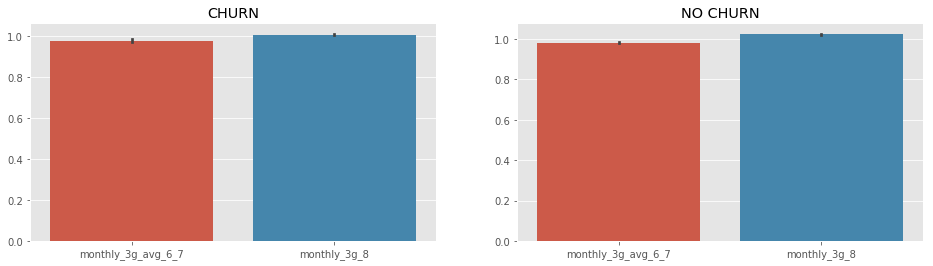

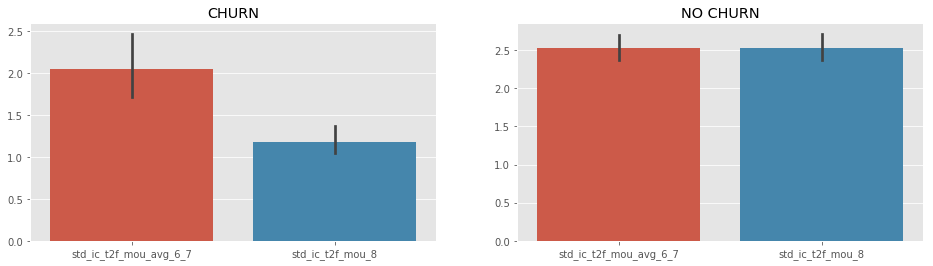

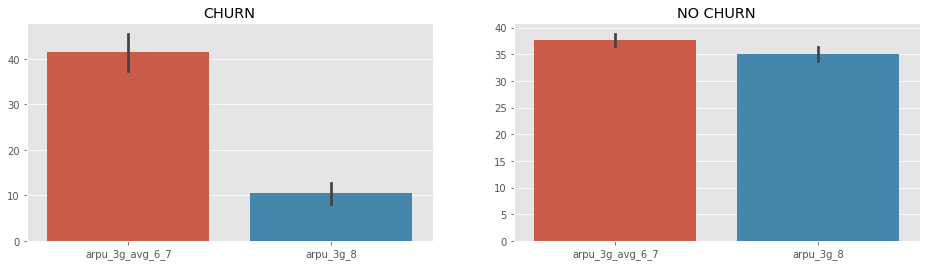

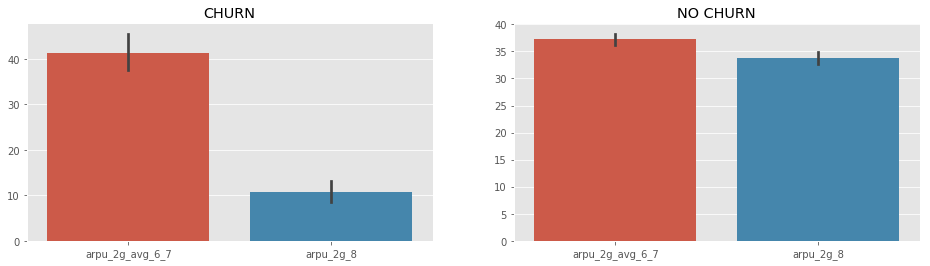

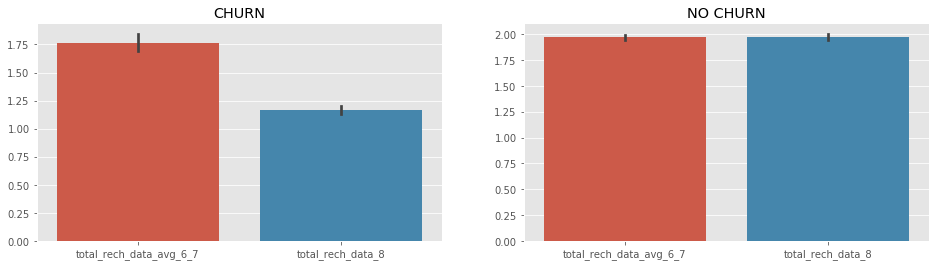

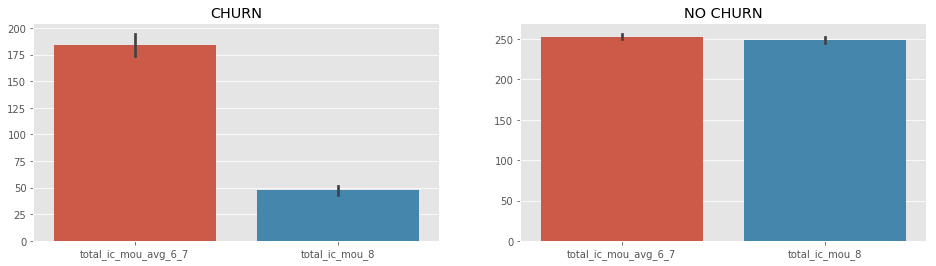

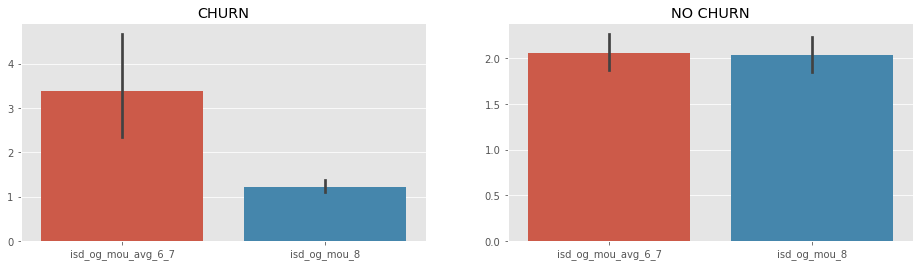

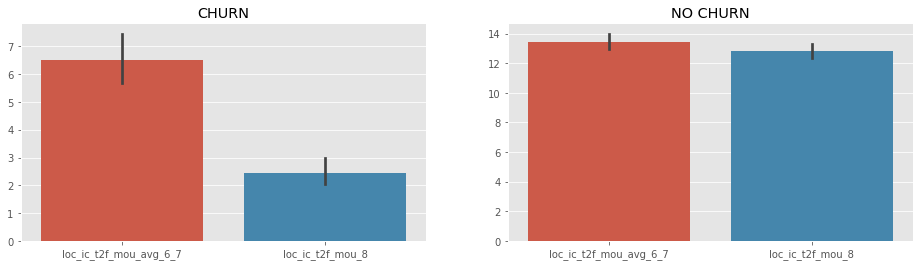

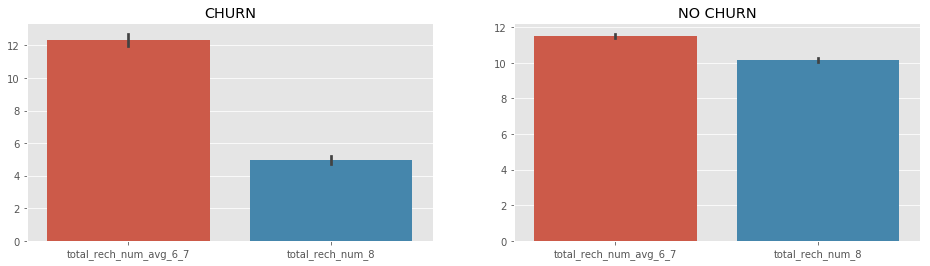

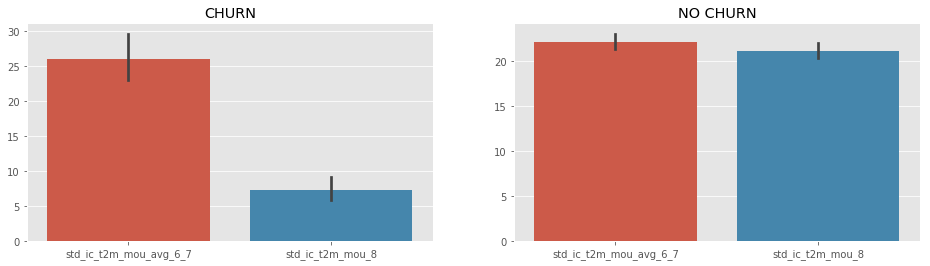

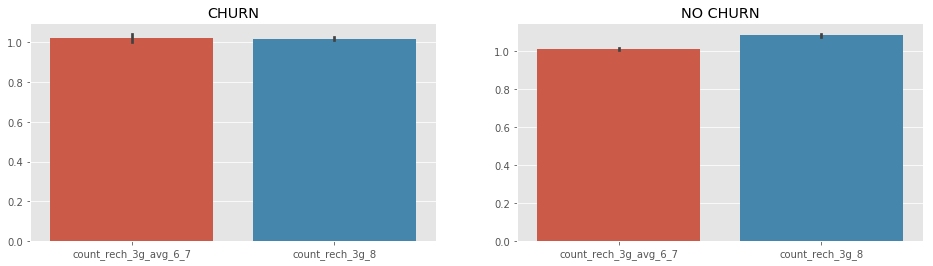

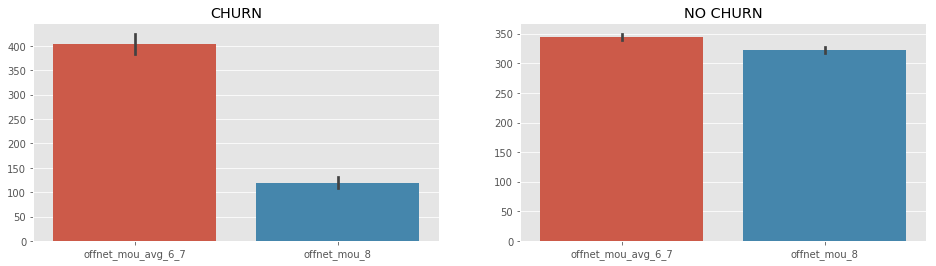

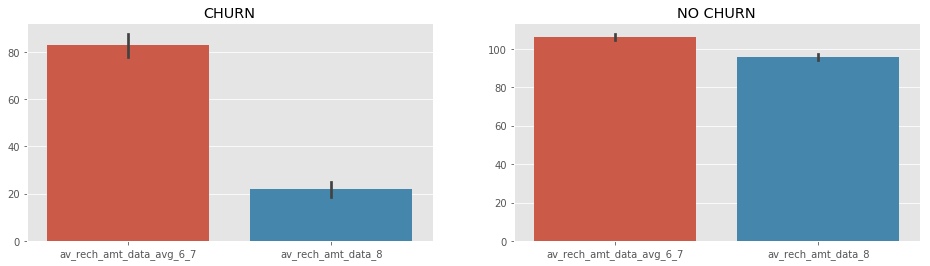

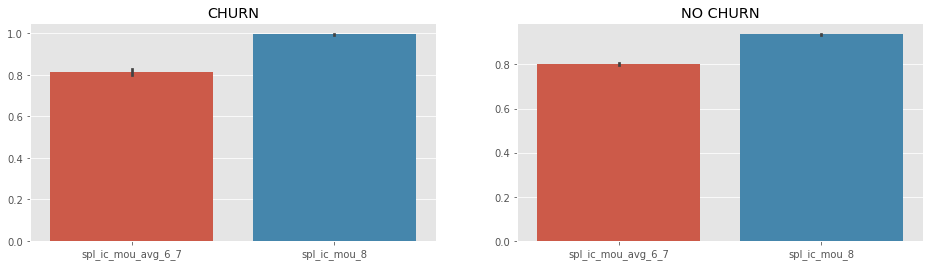

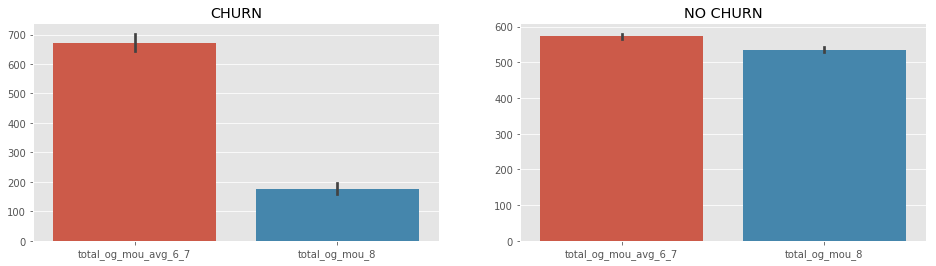

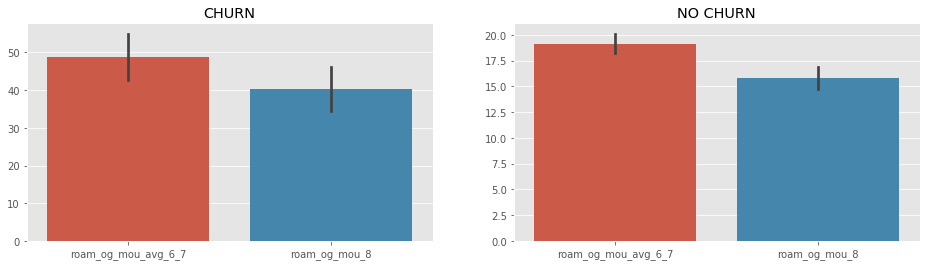

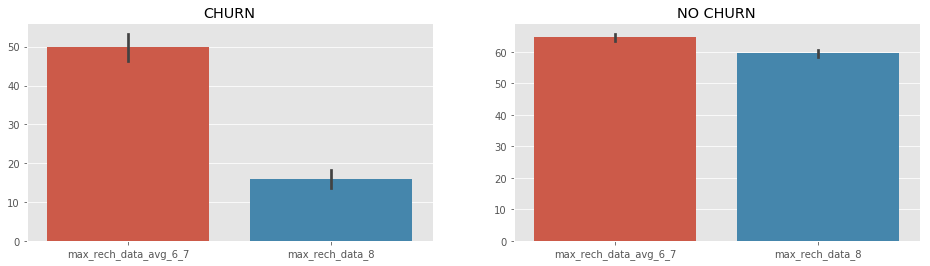

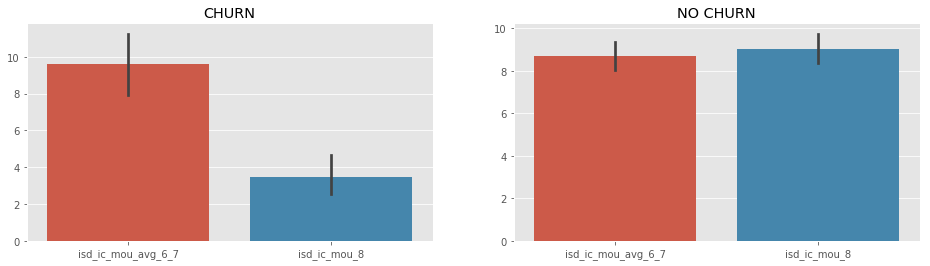

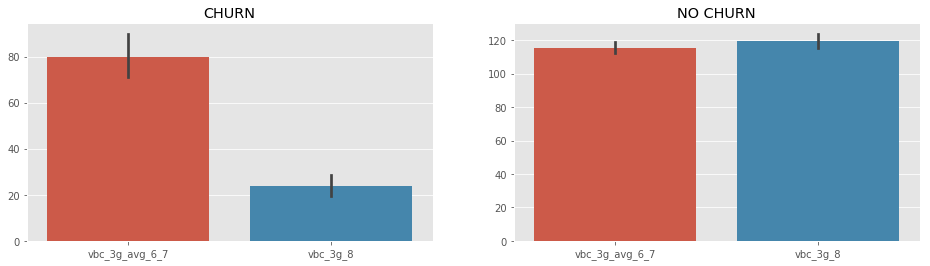

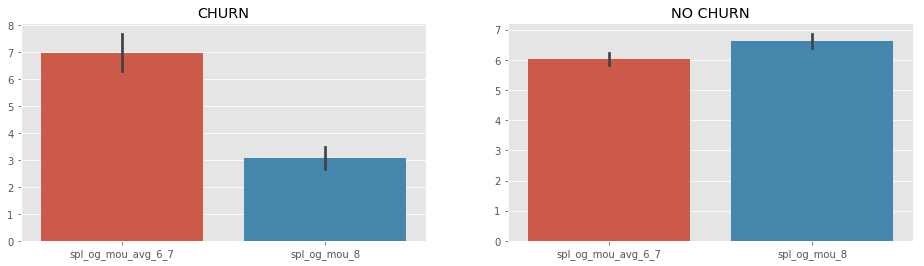

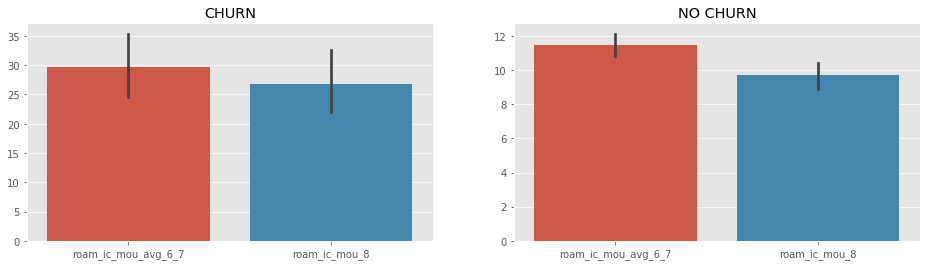

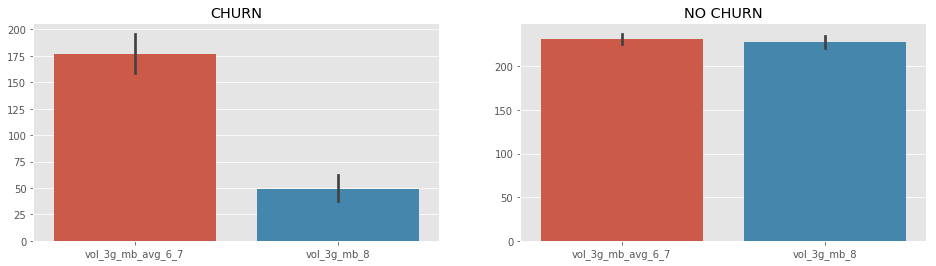

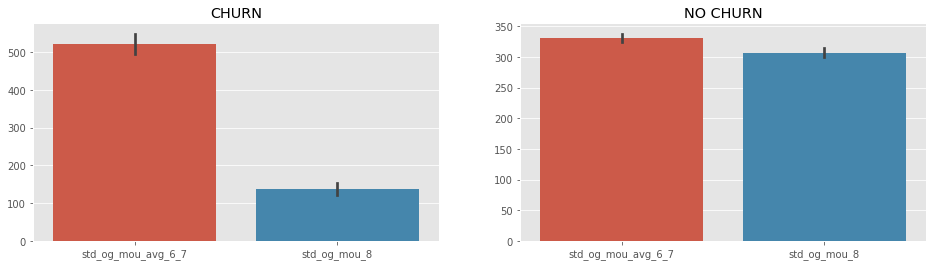

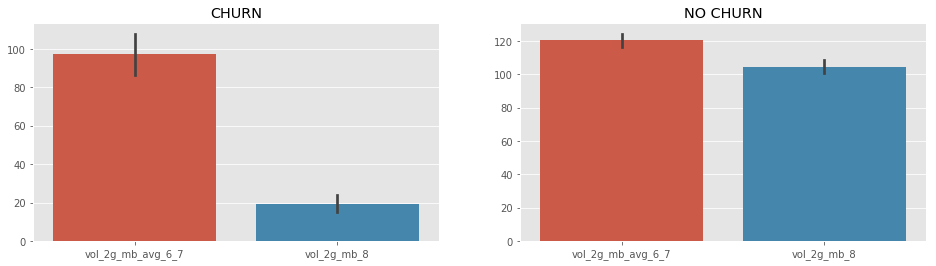

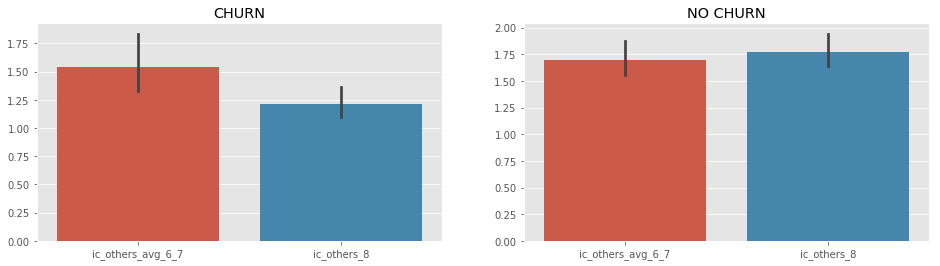

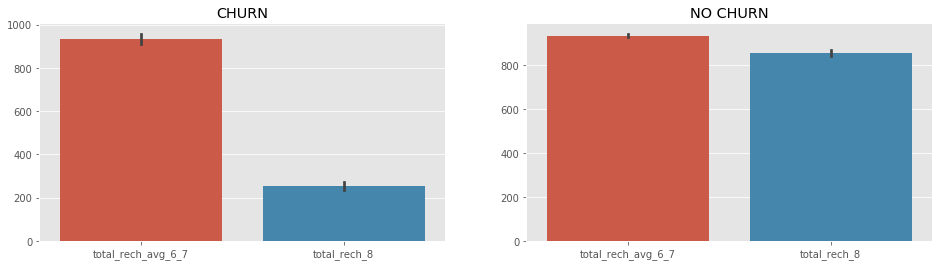

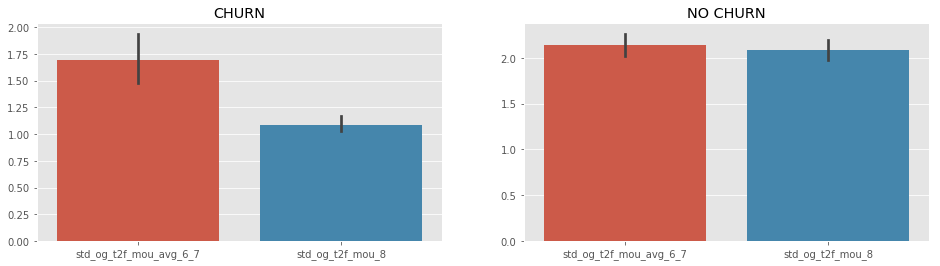

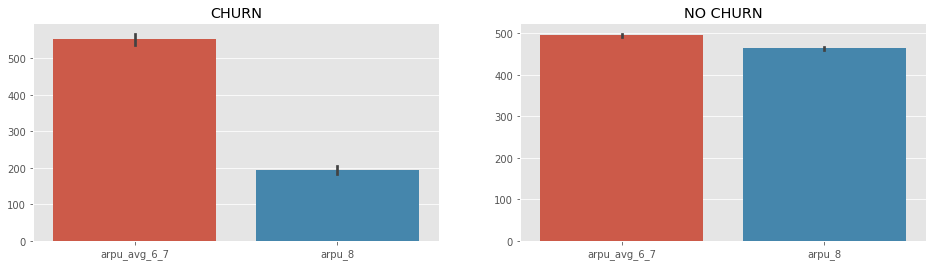

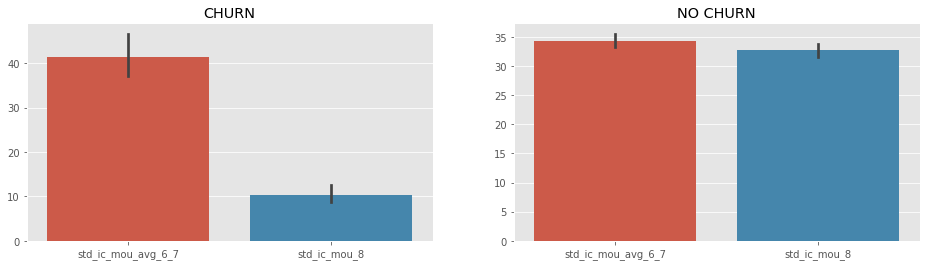

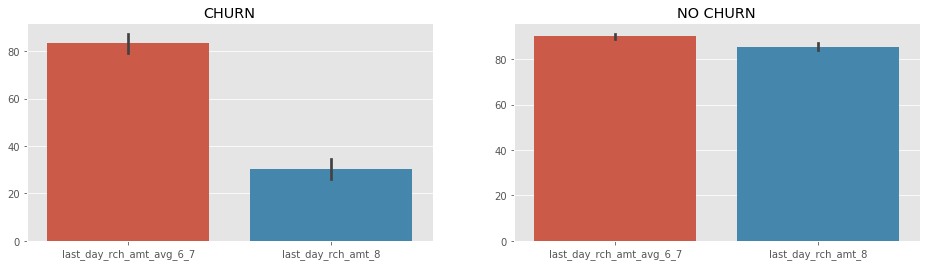

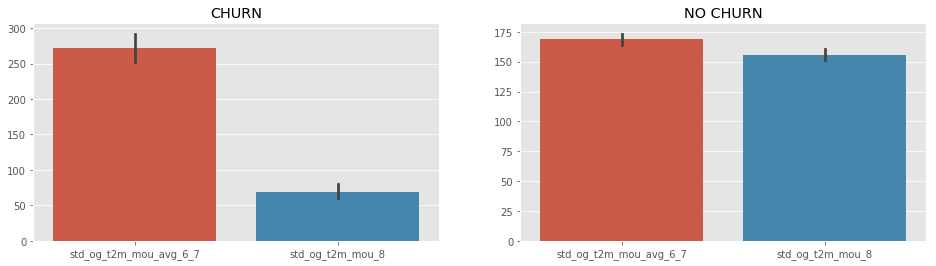

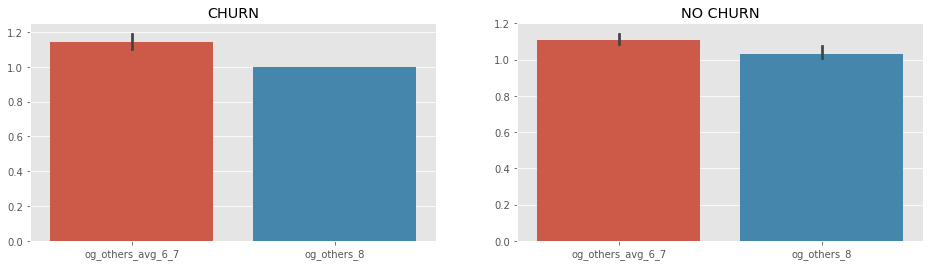

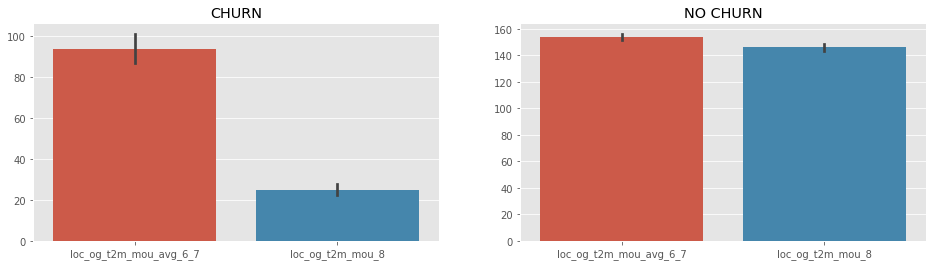

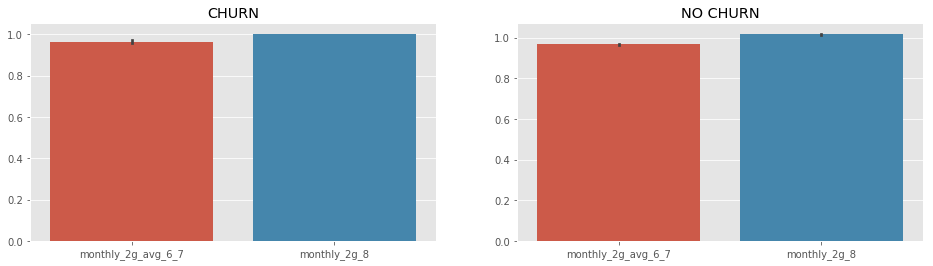

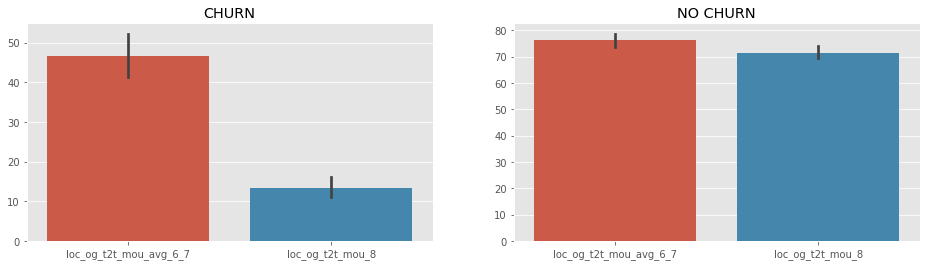

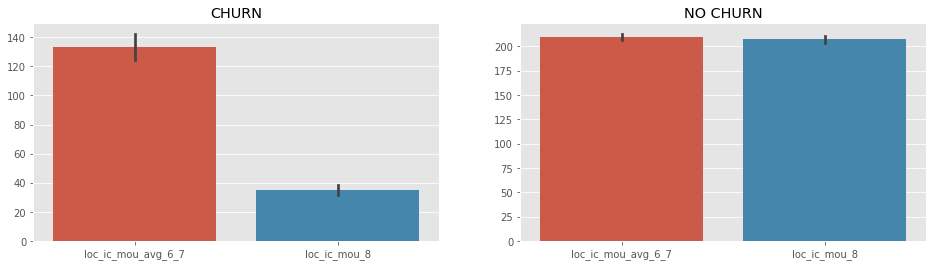

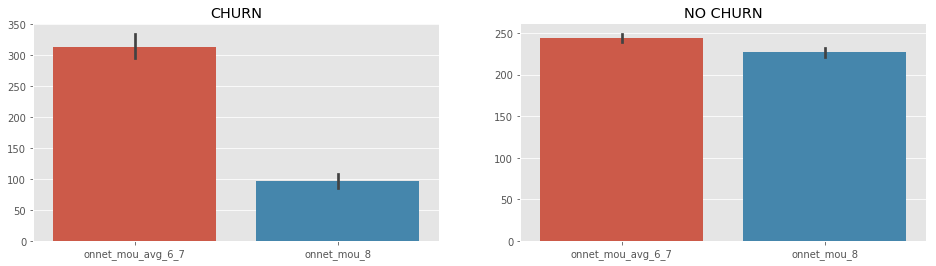

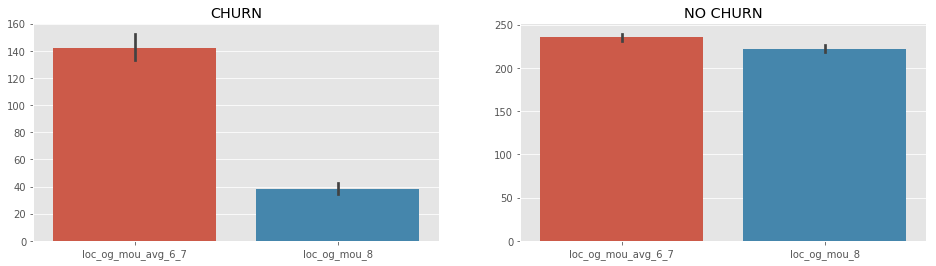

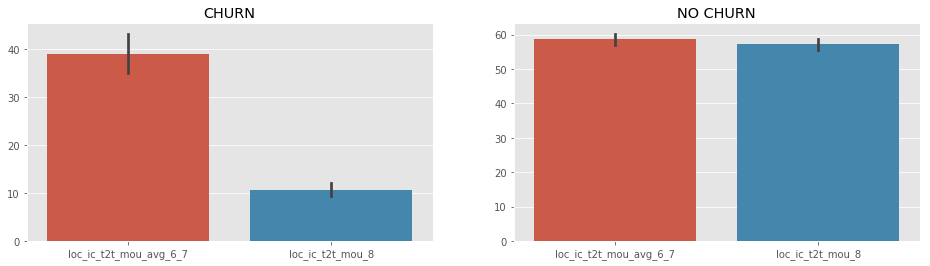

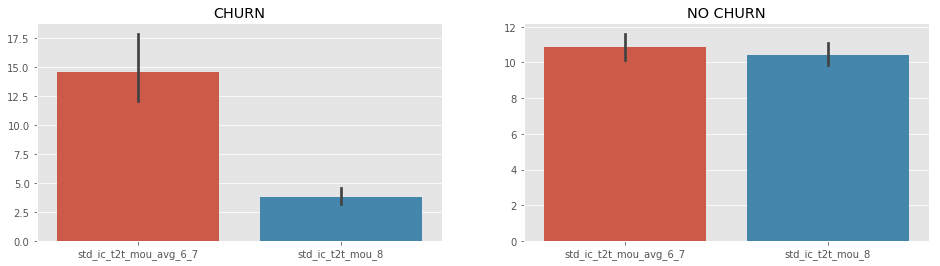

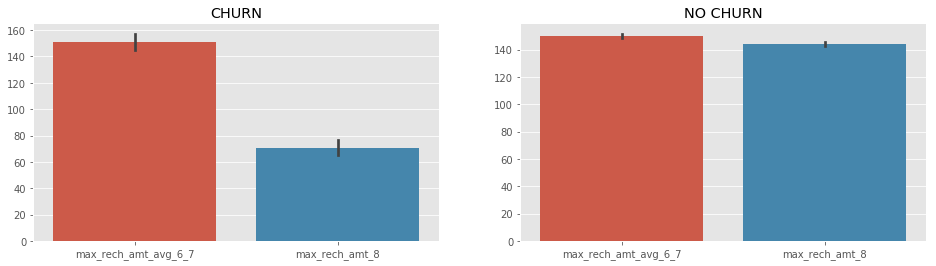

In [52]:
compare_churn_nonchurn(num_variables)

### Inference:

#### The pattern is quite clear from the above plots: Among the churned customers, almost all metrics (outgoing mou, incoming mou, recharge amount, etc), show a steep decline from the 'good' phase to 'action' phase. The decline is about 70% from month 6 to month 8.

#### The biggest decline is seen in the amount spent on data recharge.

#### The only metrics that show a reverse in this trend for churned customers is the 'roaming' calls usage. This is presumably because many of the customers have churned owing to relocation. But that cannot be proved as the data does not contain geographical information of the customer across months.

#### However, the usage among non-churned customers remain fairly consistent across the two phases.

# Segmented Bivariate Analysis Between Months

Segmenting the data by each month for EDA.

In [77]:
CHURN = 'churn'
cols_avg_6_7 = [c for c in data.columns if(c[-8:] == '_avg_6_7' or CHURN == c)]
#cols7 = [c for c in data.columns if(c[-2:] == '_7' or CHURN == c)]
cols8 = [c for c in data.columns if(c[-2:] == '_8' or CHURN == c)]
miscc_cols = [c for c in data.columns if (c[-2:] != '_6' and c[-2:] != '_7' and c[-2:] != '_8' and c[-8:] != '_avg_6_7' ) and c != 'mobile_number']

# Segmenting the datframe by each month and misceallaneous columns
data_avg_6_7 = data[cols_avg_6_7]
#data_7 = data[cols7]
data_8 = data[cols8]
data_miscc = data[miscc_cols]

In [78]:
miscc_cols

['aon', 'churn']

### Defining some generic functions for Univariate and Multivariate analysis

#### Method to compare categorical predictors with churn

In [79]:
from IPython.display import display, HTML
def describe_categorical(idf, outcome):
    """
    Method that takes the data frame as the input and performs the Univariate and Bivariate analysis on the Categorical variables
    of the data set.

    idf -> Input Data frame
    outcome -> the variable against which variables have to be analysed

    @Author - Aryan Singh
    """
    df=idf.copy(deep=True)
    from IPython.display import display, HTML
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    cat_variables = list(set(cols) - set(num_cols))
    display(HTML('<h4>Results from describe_categorical function.</h4>'))
    display(HTML('<h5>Univariate Analysis Of the categorical variables</h5>'))
    display(HTML(df[cat_variables].describe().to_html()))
    display(HTML('<br /><h4>Bivariate Analysis of relationship between ' + outcome + ' and categorical variables</h4><br />'))
    for variable in df:
        if((str(variable) in cat_variables) & (str(variable)!=outcome)):
            display(HTML('<h5>Relationship between the ' + outcome + ' and ' + str(variable) + '</h5><br />'))
            ctb=pd.crosstab(df[variable], df[outcome]).apply(lambda r: round(r/r.sum(),2), axis=1)
            display(HTML(ctb.to_html()))
            stacked = ctb.stack().reset_index().rename(columns={0:'value'})
            display(HTML('<h5>Relationship Plot between the ' + outcome + ' and ' + str(variable) + '</h5><br />'))
            sb.barplot(x=stacked[variable], y=stacked.value, hue=stacked[outcome])
            plt.xticks(rotation=90) 
            plt.show()  

#### Method to compare numerical predictors with churn

In [80]:
def describe_quantitative(idf, outcome):
    """
    Method that takes the dat frame as input and performs the Univariate and Bivariate analysis on the Quantitative variables
    of the data set.

    idf -> Input Data frame
    outcome -> the variable against which variables have to be analysed

    @Author - Aryan Singh
    """
    df=idf.copy(deep=True)
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    num_variables = list(set(num_cols))
    num_variables.append(outcome)
    display(HTML('<h4>Results from describe_quantitative function.</h4>'))
    display(HTML('<h5>Univariate Analysis Of the numerical variables</h5>'))
    display(HTML(df[num_variables].describe().to_html()))
    display(HTML('<br /><h5>Bivariate Analysis of relationship between ' + outcome + ' and numerical variables</h5><br />'))
    for variable in df:
        if((str(variable) in num_variables) & (str(variable)!= outcome)):
            display(HTML('<h5>Relationship between the ' + outcome + ' and ' + str(variable) + '</h5><br />'))
            bins = np.linspace(df[variable].min(), df[variable].max(), 10)
            df[variable] = pd.cut(df[variable],bins)
            ctb=pd.crosstab(df[variable], df[outcome]).apply(lambda r: round(r/r.sum(),2), axis=1)
            display(HTML(ctb.to_html()))
            stacked = ctb.stack().reset_index().rename(columns={0:'value'})
            display(HTML('<h5>Relationship Plot between the ' + outcome + ' and ' + str(variable) + '</h5><br />'))
            sb.barplot(x=stacked[variable], y=stacked.value, hue=stacked[outcome])
            plt.xticks(rotation=90) 
            plt.show() 

In [94]:
def get_common_cols(dfs):
    """
    Method that takes the variable and dataframe to generate a cross table.
    
    @Author - Aryan Singh    
    """
    cols = set(dfs[0]._get_numeric_data().columns)
    for df in dfs:
        dfcols = set(df._get_numeric_data().columns)
        cols = cols.intersection(dfcols)
    return cols

def get_cross_tab(df, variable, outcome):
    """
    Method that takes the variable and dataframe to generate a cross table.
    
    @Author - Aryan Singh    
    """
    if(variable!='fb_user'):
        df[variable] = pd.qcut(df[variable],10, duplicates = 'drop')
    ctb=pd.crosstab(df[variable], df[outcome]).apply(lambda r: round(r/r.sum(),2), axis=1)
    return ctb

def get_barplot_ctab(ctab, variable, outcome, ax):
    """
    Method that takes in crosstable and plots the corresponding barplot.
    
    @Author - Aryan Singh
    """
    stacked = ctab.stack().reset_index().rename(columns={0:'value'})
    sb.barplot(x=stacked[variable], y=stacked.value, hue=stacked[outcome], ax=ax)
    
def simultaneous_quant_analysis(dfs, outcome):
    """
    Method that takes a list of dataframes and does a side by side bivariate analysis against the outcome variable.

    dfs -> List of dataframes
    outcome -> the variable against which variables have to be analysed

    @Author - Aryan Singh
    """ 
    df_avg_6_7 = dfs[0]
    df_8 = dfs[1]
    df_avg_6_7.columns = [c[:-8] if c != CHURN else c for c in df_avg_6_7.columns]
    df_8.columns = [c[:-2] if c != CHURN else c for c in df_8.columns]
    cols = get_common_cols(dfs)
    for variable in cols:
        if(str(variable)!= outcome):
            display(HTML('<h5>Relationship between the ' + outcome + ' and ' + str(variable) + ' across June, July, August.</h5><br />'))
            ctab_6_7 = get_cross_tab(df_avg_6_7, variable, outcome)
            #ctab_7 = get_cross_tab(df_7, variable, outcome)
            ctab_8 = get_cross_tab(df_8, variable, outcome)
            display(HTML('<table><tr><td>' + ctab_6_7.to_html() + '</td><td>' + ctab_8.to_html() + '</td></tr></table><br />'))
            display(HTML('<h5>Relationship Plot between the ' + outcome + ' and ' + str(variable) + ' across June, July, August.</h5>'))
            fig, ax =plt.subplots(1,2)
            plt.tight_layout()
            plt.xticks(rotation=90)
            get_barplot_ctab(ctab_6_7, variable, outcome, ax[0])
            #get_barplot_ctab(ctab_7, variable, outcome, ax[1])
            get_barplot_ctab(ctab_8, variable, outcome, ax[1])
            plt.show()

#### Method that does Univariate Analysis on a quantitative variable

In [82]:
def uni_quant(df, var):
    """
    Method that takes in the dataframe and a quantitaive variable and gives out the univariate analysis.
    
    @Author- Aryan Singh
    """
    plt.figure(figsize=(14,12))
    sb.set(font_scale=1)
    plt.subplot(121)
    sb.distplot(df[var])
    plt.subplot(122)
    sb.boxplot(y=var,data=df)
    plt.show()

### Analysing Miscellaneous Columns

There is one miscellaneous column in aon which signifies the age on netwrok. Let's look at it's EDA

### Univariate Analysis

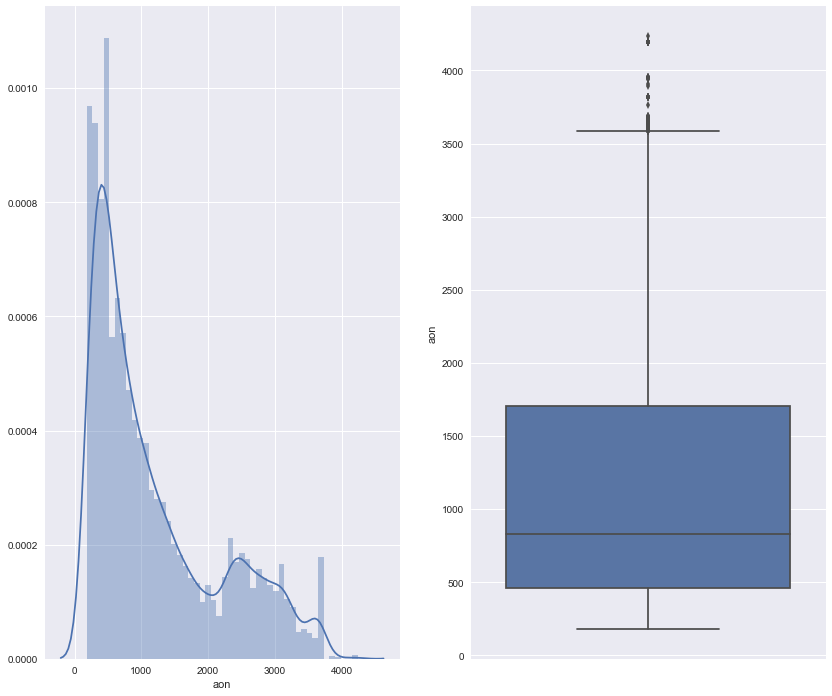

In [83]:
uni_quant(data,'aon')

The distribution of aon variable is skewed and most of the customers are those whose age on network is less. Also the distribution soes not have any outliers and variance is somewhat low.

### Bivariate Analysis

,aon,churn,churn
count,25323.000000,25323.00000,25323.00000
mean,1192.016744,0.08822,0.08822
std,947.186650,0.28362,0.28362
min,180.000000,0.00000,0.00000
25%,458.000000,0.00000,0.00000
50%,833.000000,0.00000,0.00000
75%,1708.000000,0.00000,0.00000
max,4235.000000,1.00000,1.00000


churn,0,1
aon,,
"(180.0, 630.556]",0.88,0.12
"(630.556, 1081.111]",0.90,0.10
"(1081.111, 1531.667]",0.93,0.07
"(1531.667, 1982.222]",0.94,0.06
"(1982.222, 2432.778]",0.96,0.04
"(2432.778, 2883.333]",0.96,0.04
"(2883.333, 3333.889]",0.96,0.04
"(3333.889, 3784.444]",0.96,0.04
"(3784.444, 4235.0]",1.00,0.00


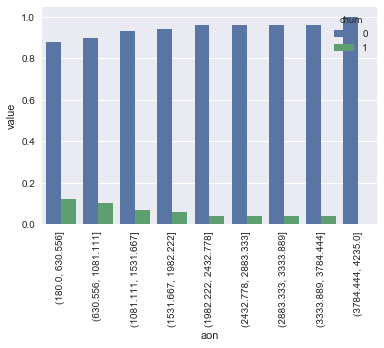

In [84]:
describe_quantitative(data_miscc,CHURN)

**Conclusion:** The customers whoose age on network is less are more likely to churn.

### Analysing Monthly Segments

Before analysing the monthly segments, lets take a look at tbe correlation metrics to get rid of the correlated columns before analysis.

**Checking Correlation**

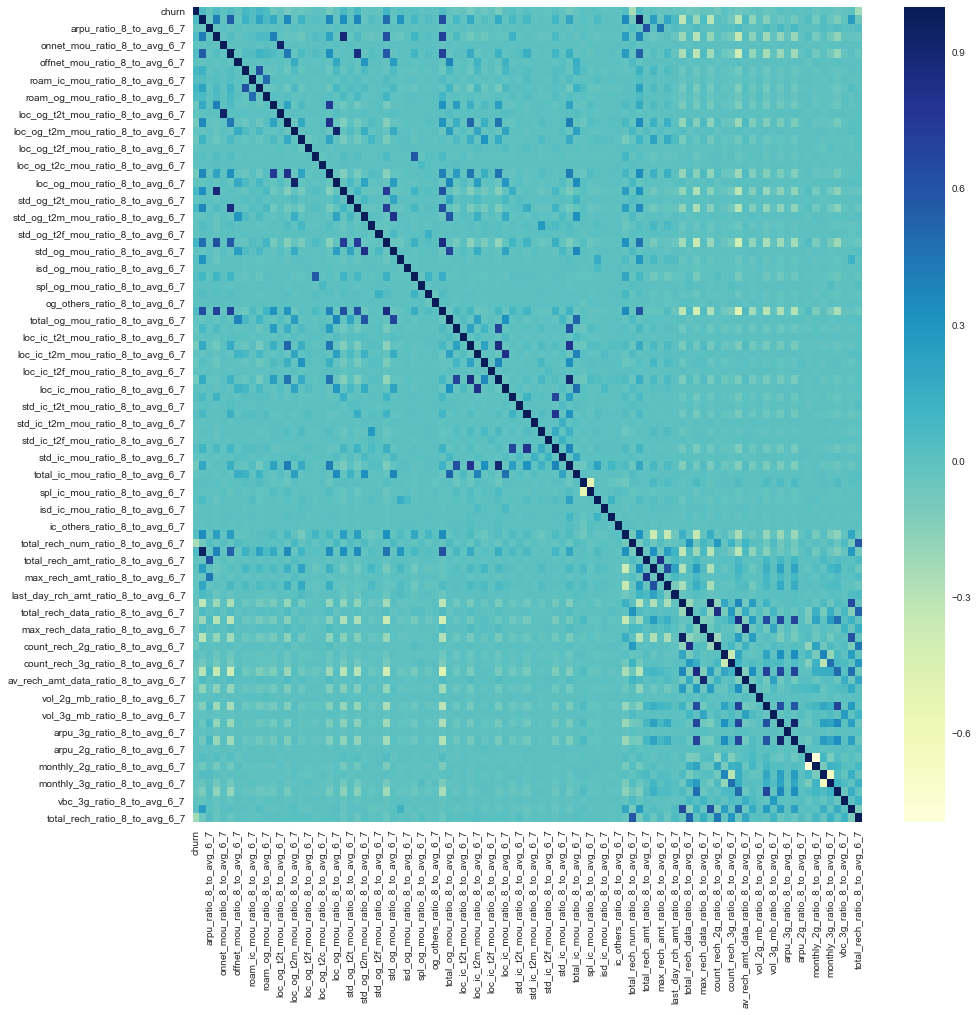

In [86]:
plt.figure(figsize=(15,15))
# Create correlation matrix
corr = data_avg_6_7.corr()
sb.set(font_scale=1)
sb.heatmap(corr, cmap="YlGnBu", annot=False)

There is not much correlation in the average columns of 6th and 7th months.

In [87]:
def get_correlated_columns_cut_off(df, cut_off):
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than cut off
    to_drop = [column for column in upper.columns if any(upper[column] > cut_off)]
    return to_drop

In [88]:
data_avg_6_7.drop(get_correlated_columns_cut_off(data_avg_6_7, 0.80), axis=1, inplace=True)

**Doing similar analysis for the month of August **

**August**

In [89]:
data_8.drop(get_correlated_columns_cut_off(data_8, 0.80), axis=1, inplace=True)

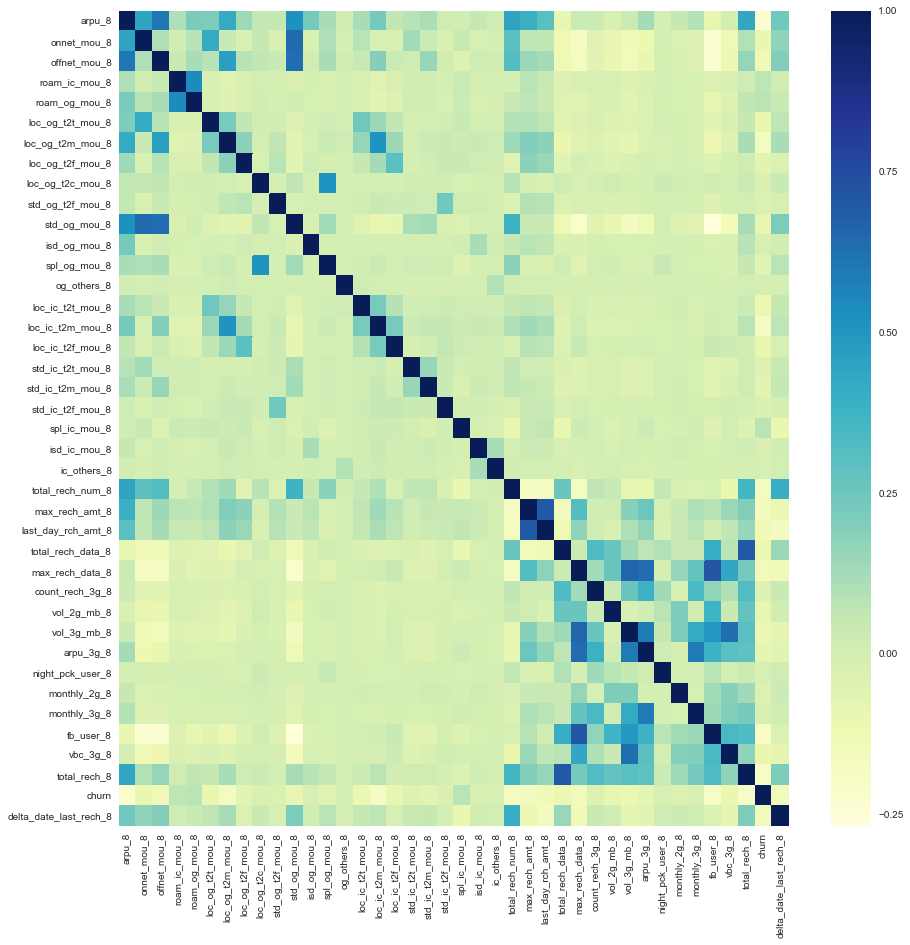

In [90]:
plt.figure(figsize=(15,15))
# Create correlation matrix
corr = data_8.corr()
sb.set(font_scale=1)
sb.heatmap(corr, cmap="YlGnBu", annot=False)

### Analysis Of Metric Metamorphosis Across Months

churn,0,1
loc_ic_t2m_mou,,
"(0.004, 9.371]",0.81,0.19
"(9.371, 23.632]",0.87,0.13
"(23.632, 40.163]",0.89,0.11
"(40.163, 58.911]",0.91,0.09
"(58.911, 80.97]",0.91,0.09
"(80.97, 110.0]",0.93,0.07
"(110.0, 148.687]",0.93,0.07
"(148.687, 205.368]",0.95,0.05
"(205.368, 313.355]",0.96,0.04


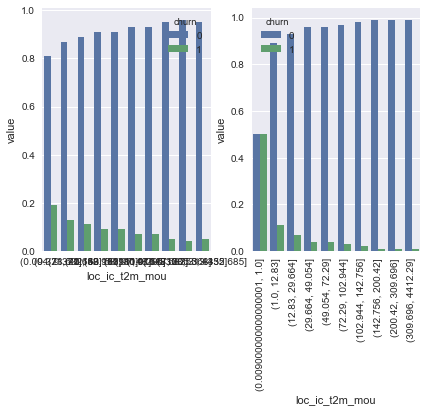

churn,0,1
loc_og_t2c_mou,,
"(0.004, 0.661]",0.90,0.10
"(0.661, 1.0]",0.91,0.09
"(1.0, 1.63]",0.90,0.10
"(1.63, 4.195]",0.91,0.09
"(4.195, 420.575]",0.91,0.09
churn,0,1
loc_og_t2c_mou,,
"(0.009000000000000001, 1.0]",0.90,0.10
"(1.0, 3.98]",0.96,0.04


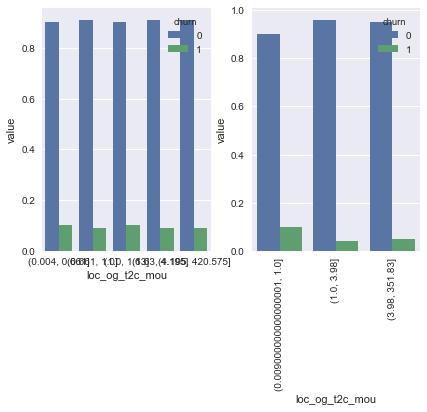

churn,0,1
loc_og_t2f_mou,,
"(0.004, 0.52]",0.93,0.07
"(0.52, 1.0]",0.88,0.12
"(1.0, 1.14]",0.94,0.06
"(1.14, 2.49]",0.94,0.06
"(2.49, 5.16]",0.94,0.06
"(5.16, 12.094]",0.94,0.06
"(12.094, 714.27]",0.96,0.04
churn,0,1
loc_og_t2f_mou,,


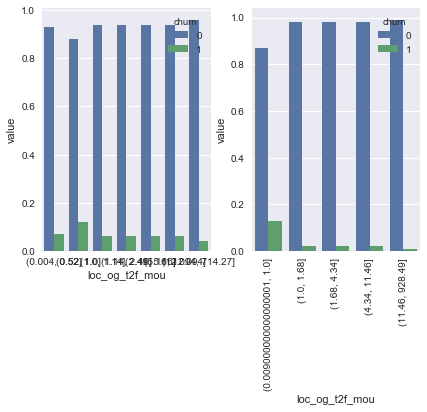

churn,0,1
monthly_3g,,
"(0.499, 1.0]",0.91,0.09
"(1.0, 6.0]",0.93,0.07
churn,0,1
monthly_3g,,
"(0.999, 5.0]",0.91,0.09


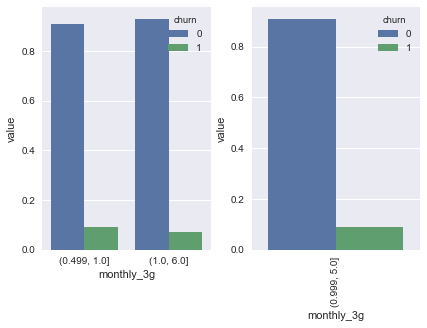

churn,0,1
std_ic_t2f_mou,,
"(0.004, 0.59]",0.94,0.06
"(0.59, 1.0]",0.90,0.10
"(1.0, 3.03]",0.94,0.06
"(3.03, 1029.125]",0.94,0.06
churn,0,1
std_ic_t2f_mou,,
"(0.009000000000000001, 1.0]",0.90,0.10
"(1.0, 2.326]",0.98,0.02
"(2.326, 907.21]",0.99,0.01


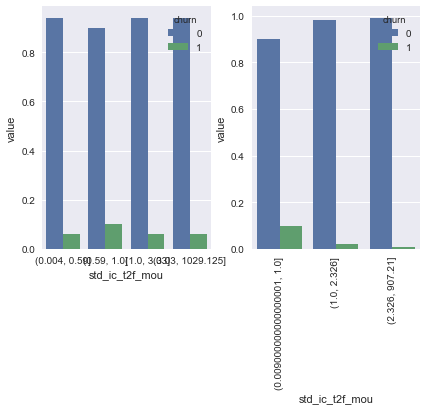

churn,0,1
arpu_3g,,
"(-15.136, 1.0]",0.91,0.09
"(1.0, 9.815]",0.95,0.05
"(9.815, 49.349]",0.93,0.07
"(49.349, 129.927]",0.92,0.08
"(129.927, 1272.885]",0.90,0.10
churn,0,1
arpu_3g,,
"(-24.491, 1.0]",0.89,0.11
"(1.0, 8.472]",0.98,0.02


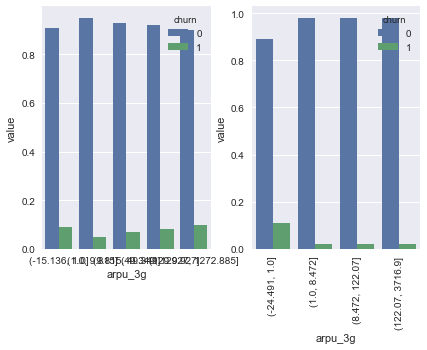

churn,0,1
total_rech_data,,
"(0.499, 1.0]",0.90,0.10
"(1.0, 1.5]",0.95,0.05
"(1.5, 2.5]",0.93,0.07
"(2.5, 4.5]",0.93,0.07
"(4.5, 27.5]",0.92,0.08
churn,0,1
total_rech_data,,
"(0.999, 2.0]",0.90,0.10
"(2.0, 4.0]",0.97,0.03


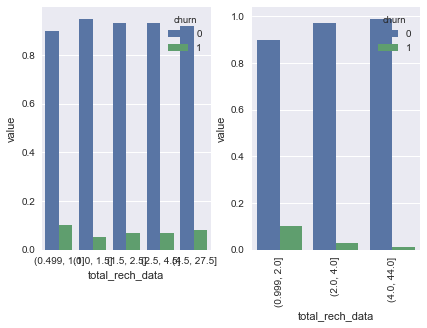

churn,0,1
isd_og_mou,,
"(0.004, 1.0]",0.91,0.09
"(1.0, 1041.295]",0.89,0.11
churn,0,1
isd_og_mou,,
"(0.009000000000000001, 1.0]",0.91,0.09
"(1.0, 892.61]",0.95,0.05


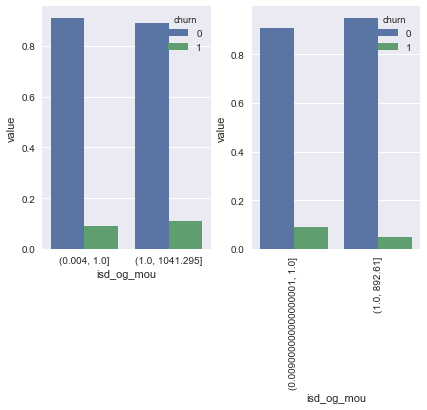

churn,0,1
loc_ic_t2f_mou,,
"(0.004, 0.5]",0.90,0.10
"(0.5, 1.0]",0.86,0.14
"(1.0, 2.07]",0.91,0.09
"(2.07, 4.07]",0.93,0.07
"(4.07, 7.64]",0.94,0.06
"(7.64, 14.485]",0.94,0.06
"(14.485, 30.184]",0.95,0.05
"(30.184, 1358.435]",0.96,0.04
churn,0,1


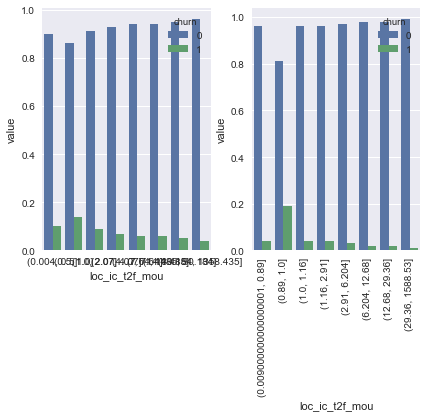

churn,0,1
total_rech_num,,
"(0.499, 4.5]",0.91,0.09
"(4.5, 5.5]",0.93,0.07
"(5.5, 7.0]",0.93,0.07
"(7.0, 8.0]",0.92,0.08
"(8.0, 9.5]",0.92,0.08
"(9.5, 11.0]",0.91,0.09
"(11.0, 13.0]",0.91,0.09
"(13.0, 16.0]",0.90,0.10
"(16.0, 21.5]",0.90,0.10


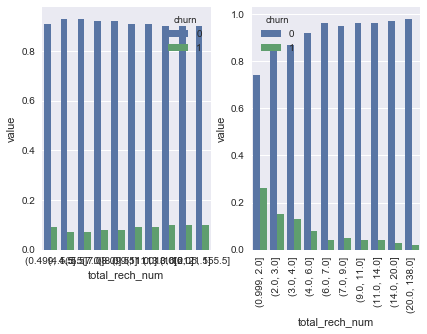

churn,0,1
std_ic_t2m_mou,,
"(0.004, 0.88]",0.93,0.07
"(0.88, 1.0]",0.91,0.09
"(1.0, 1.09]",0.89,0.11
"(1.09, 2.949]",0.92,0.08
"(2.949, 5.975]",0.92,0.08
"(5.975, 10.162]",0.91,0.09
"(10.162, 16.74]",0.91,0.09
"(16.74, 28.198]",0.90,0.10
"(28.198, 51.858]",0.91,0.09


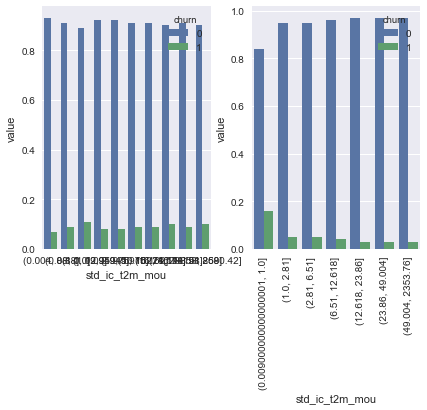

churn,0,1
count_rech_3g,,
"(0.499, 1.0]",0.91,0.09
"(1.0, 12.5]",0.91,0.09
churn,0,1
count_rech_3g,,
"(0.999, 30.0]",0.91,0.09


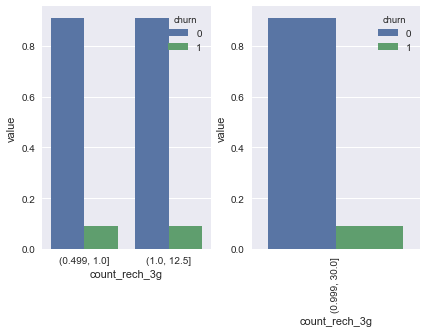

churn,0,1
offnet_mou,,
"(0.004, 15.417]",0.89,0.11
"(15.417, 52.92]",0.92,0.08
"(52.92, 99.497]",0.92,0.08
"(99.497, 154.671]",0.92,0.08
"(154.671, 221.785]",0.92,0.08
"(221.785, 305.968]",0.92,0.08
"(305.968, 409.574]",0.93,0.07
"(409.574, 561.455]",0.92,0.08
"(561.455, 845.47]",0.91,0.09


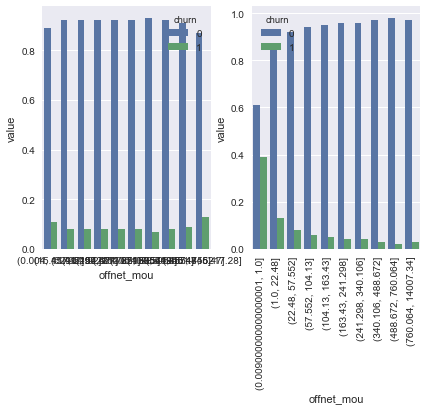

churn,0,1
spl_ic_mou,,
"(0.004, 0.105]",0.92,0.08
"(0.105, 0.28]",0.91,0.09
"(0.28, 1.0]",0.91,0.09
"(1.0, 10.665]",1.00,0.00
churn,0,1
spl_ic_mou,,
"(0.009000000000000001, 1.0]",0.91,0.09
"(1.0, 1.25]",1.00,0.00


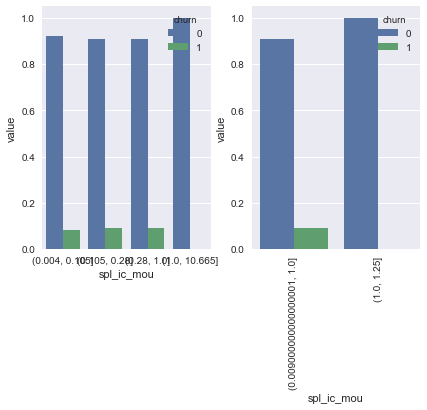

churn,0,1
max_rech_data,,
"(0.499, 1.0]",0.89,0.11
"(1.0, 8.5]",0.91,0.09
"(8.5, 23.0]",0.90,0.10
"(23.0, 45.5]",0.92,0.08
"(45.5, 97.5]",0.90,0.10
"(97.5, 149.5]",0.92,0.08
"(149.5, 176.0]",0.97,0.03
"(176.0, 977.0]",0.94,0.06
churn,0,1


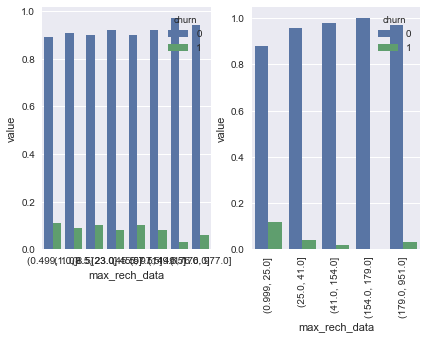

churn,0,1
roam_og_mou,,
"(0.004, 1.0]",0.93,0.07
"(1.0, 7.755]",0.87,0.13
"(7.755, 44.825]",0.86,0.14
"(44.825, 2039.57]",0.84,0.16
churn,0,1
roam_og_mou,,
"(0.009000000000000001, 1.0]",0.93,0.07
"(1.0, 20.888]",0.77,0.23
"(20.888, 3493.36]",0.80,0.20


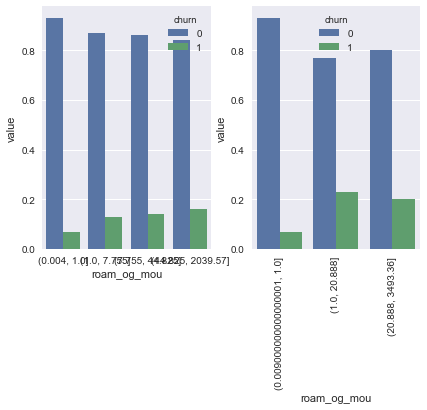

churn,0,1
vbc_3g,,
"(0.009000000000000001, 1.0]",0.90,0.10
"(1.0, 23.557]",0.93,0.07
"(23.557, 151.681]",0.92,0.08
"(151.681, 398.569]",0.94,0.06
"(398.569, 4349.46]",0.94,0.06
churn,0,1
vbc_3g,,
"(0.019, 1.0]",0.89,0.11
"(1.0, 123.216]",0.95,0.05


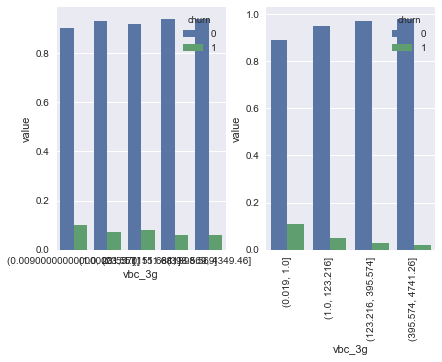

churn,0,1
isd_ic_mou,,
"(0.004, 1.0]",0.91,0.09
"(1.0, 10.584]",0.92,0.08
"(10.584, 1833.975]",0.90,0.10
churn,0,1
isd_ic_mou,,
"(0.009000000000000001, 1.0]",0.90,0.10
"(1.0, 7.988]",0.96,0.04
"(7.988, 3432.88]",0.96,0.04


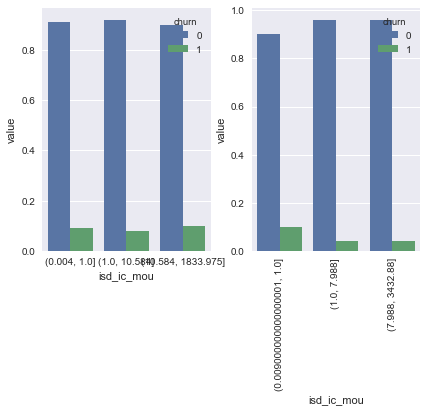

churn,0,1
spl_og_mou,,
"(0.004, 0.555]",0.93,0.07
"(0.555, 1.0]",0.91,0.09
"(1.0, 1.525]",0.90,0.10
"(1.525, 2.955]",0.91,0.09
"(2.955, 4.985]",0.91,0.09
"(4.985, 8.32]",0.92,0.08
"(8.32, 15.005]",0.91,0.09
"(15.005, 572.12]",0.90,0.10
churn,0,1


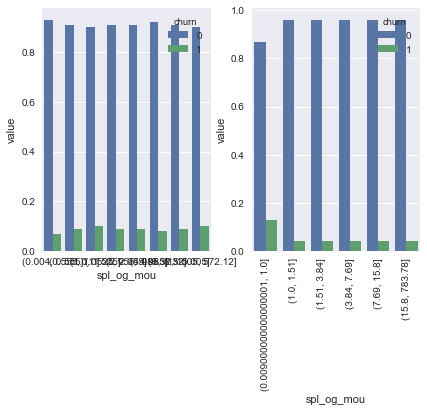

churn,0,1
roam_ic_mou,,
"(0.004, 1.0]",0.93,0.07
"(1.0, 3.275]",0.84,0.16
"(3.275, 20.698]",0.87,0.13
"(20.698, 3060.6]",0.86,0.14
churn,0,1
roam_ic_mou,,
"(0.009000000000000001, 1.0]",0.93,0.07
"(1.0, 10.04]",0.74,0.26
"(10.04, 4169.81]",0.82,0.18


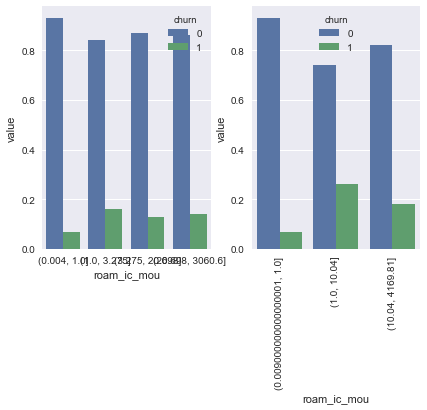

churn,0,1
vol_3g_mb,,
"(0.004, 1.0]",0.90,0.10
"(1.0, 131.177]",0.92,0.08
"(131.177, 421.129]",0.92,0.08
"(421.129, 806.104]",0.94,0.06
"(806.104, 6279.28]",0.94,0.06
churn,0,1
vol_3g_mb,,
"(0.009000000000000001, 1.0]",0.89,0.11
"(1.0, 319.998]",0.96,0.04


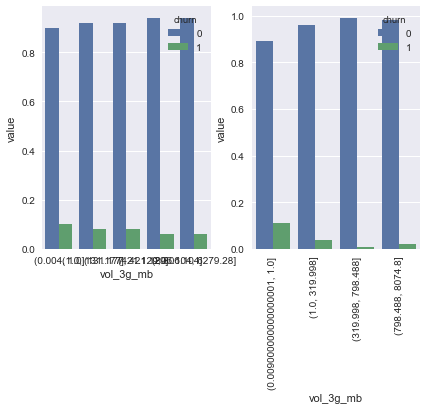

churn,0,1
std_og_mou,,
"(0.004, 1.0]",0.92,0.08
"(1.0, 3.363]",0.95,0.05
"(3.363, 13.939]",0.94,0.06
"(13.939, 53.945]",0.94,0.06
"(53.945, 180.342]",0.92,0.08
"(180.342, 410.192]",0.91,0.09
"(410.192, 707.074]",0.89,0.11
"(707.074, 1082.413]",0.89,0.11
"(1082.413, 6161.195]",0.85,0.15


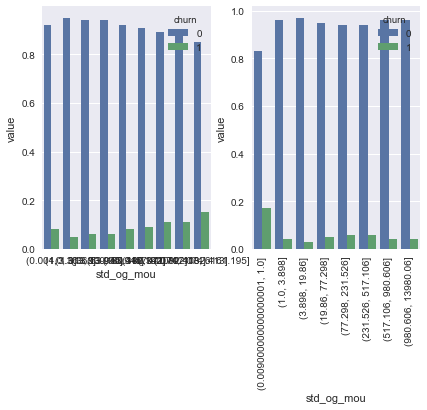

churn,0,1
vol_2g_mb,,
"(0.004, 1.0]",0.90,0.10
"(1.0, 1.685]",0.93,0.07
"(1.685, 17.066]",0.92,0.08
"(17.066, 54.79]",0.93,0.07
"(54.79, 153.635]",0.93,0.07
"(153.635, 378.805]",0.92,0.08
"(378.805, 7543.305]",0.93,0.07
churn,0,1
vol_2g_mb,,


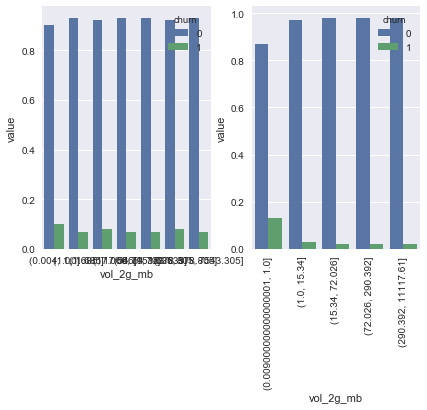

churn,0,1
ic_others,,
"(0.004, 0.215]",0.91,0.09
"(0.215, 0.84]",0.92,0.08
"(0.84, 1.0]",0.91,0.09
"(1.0, 1.354]",0.93,0.07
"(1.354, 1420.04]",0.92,0.08
churn,0,1
ic_others,,
"(0.009000000000000001, 0.51]",0.98,0.02
"(0.51, 1.0]",0.90,0.10


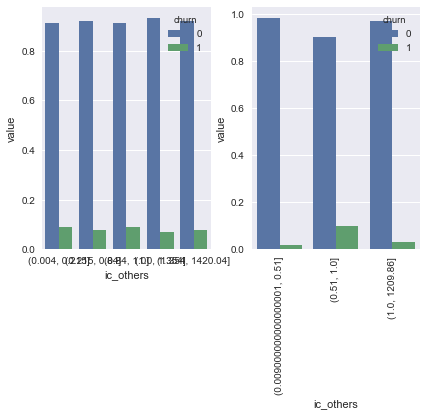

churn,0,1
total_rech,,
"(477.999, 514.0]",0.91,0.09
"(514.0, 557.0]",0.91,0.09
"(557.0, 609.5]",0.91,0.09
"(609.5, 668.0]",0.91,0.09
"(668.0, 742.0]",0.91,0.09
"(742.0, 832.5]",0.92,0.08
"(832.5, 960.0]",0.91,0.09
"(960.0, 1144.8]",0.91,0.09
"(1144.8, 1526.0]",0.92,0.08


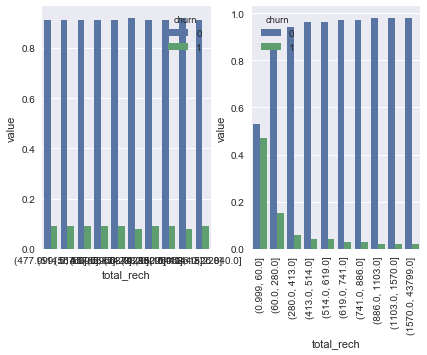

churn,0,1
std_og_t2f_mou,,
"(0.004, 1.0]",0.91,0.09
"(1.0, 1.289]",0.93,0.07
"(1.289, 382.92]",0.94,0.06
churn,0,1
std_og_t2f_mou,,
"(0.009000000000000001, 1.0]",0.91,0.09
"(1.0, 354.16]",0.99,0.01


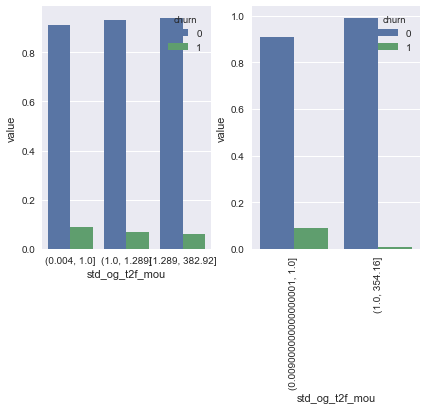

churn,0,1
last_day_rch_amt,,
"(0.999, 15.0]",0.88,0.12
"(15.0, 25.0]",0.91,0.09
"(25.0, 36.5]",0.92,0.08
"(36.5, 55.0]",0.88,0.12
"(55.0, 71.0]",0.90,0.10
"(71.0, 90.0]",0.92,0.08
"(90.0, 114.0]",0.92,0.08
"(114.0, 125.0]",0.94,0.06
"(125.0, 174.0]",0.93,0.07


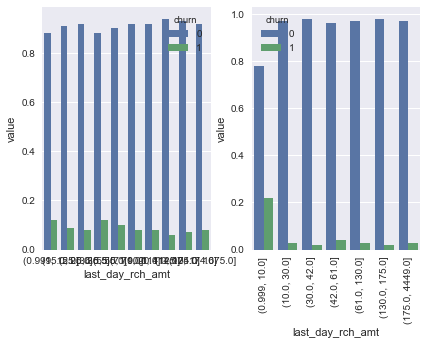

churn,0,1
og_others,,
"(0.004, 0.75]",0.90,0.10
"(0.75, 1.0]",0.91,0.09
"(1.0, 1.03]",0.91,0.09
"(1.03, 304.905]",0.90,0.10
churn,0,1
og_others,,
"(0.009000000000000001, 1.0]",0.91,0.09
"(1.0, 394.93]",1.00,0.00


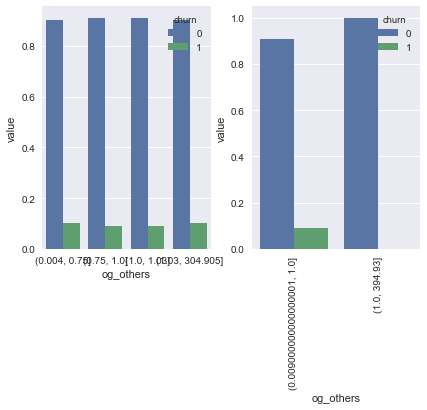

churn,0,1
loc_og_t2m_mou,,
"(0.004, 3.866]",0.84,0.16
"(3.866, 15.175]",0.88,0.12
"(15.175, 29.695]",0.88,0.12
"(29.695, 48.677]",0.90,0.10
"(48.677, 75.175]",0.91,0.09
"(75.175, 109.626]",0.92,0.08
"(109.626, 160.177]",0.93,0.07
"(160.177, 238.931]",0.94,0.06
"(238.931, 385.133]",0.96,0.04


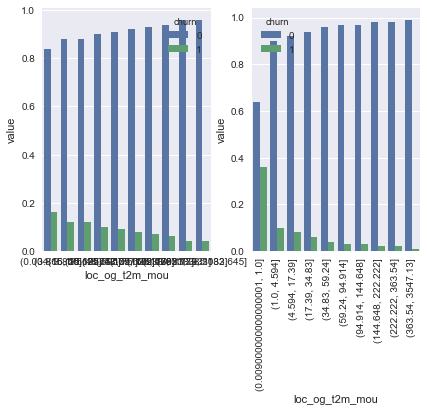

churn,0,1
monthly_2g,,
"(0.499, 1.0]",0.91,0.09
"(1.0, 3.5]",0.98,0.02
churn,0,1
monthly_2g,,
"(0.999, 5.0]",0.91,0.09


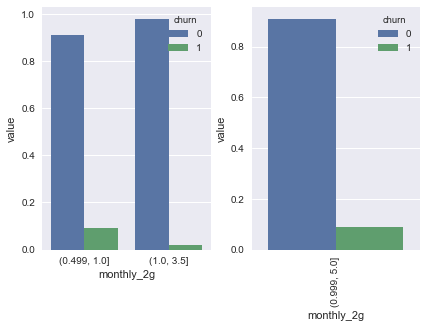

churn,0,1
loc_og_t2t_mou,,
"(0.004, 1.0]",0.85,0.15
"(1.0, 3.555]",0.90,0.10
"(3.555, 8.491]",0.89,0.11
"(8.491, 15.035]",0.91,0.09
"(15.035, 24.26]",0.90,0.10
"(24.26, 37.798]",0.92,0.08
"(37.798, 57.547]",0.93,0.07
"(57.547, 92.435]",0.94,0.06
"(92.435, 167.135]",0.94,0.06


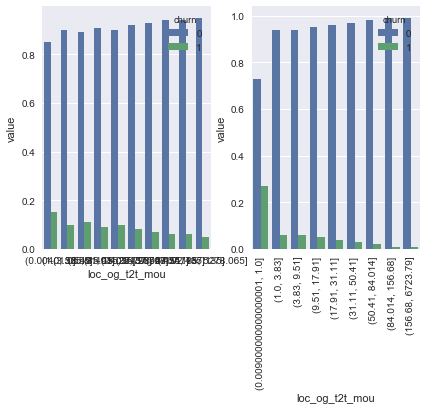

churn,0,1
onnet_mou,,
"(0.004, 1.741]",0.88,0.12
"(1.741, 11.477]",0.93,0.07
"(11.477, 27.334]",0.92,0.08
"(27.334, 52.164]",0.93,0.07
"(52.164, 87.23]",0.94,0.06
"(87.23, 142.135]",0.92,0.08
"(142.135, 226.184]",0.92,0.08
"(226.184, 402.11]",0.91,0.09
"(402.11, 745.613]",0.90,0.10


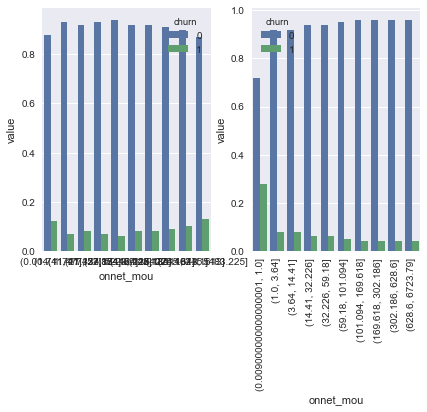

churn,0,1
arpu,,
"(-250.209, 202.211]",0.91,0.09
"(202.211, 286.15]",0.92,0.08
"(286.15, 360.645]",0.94,0.06
"(360.645, 418.914]",0.93,0.07
"(418.914, 461.037]",0.92,0.08
"(461.037, 510.012]",0.91,0.09
"(510.012, 574.152]",0.91,0.09
"(574.152, 666.686]",0.91,0.09
"(666.686, 824.915]",0.90,0.10


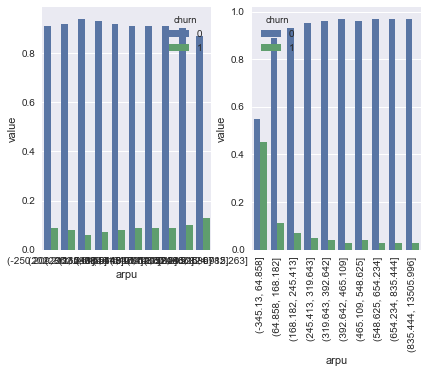

churn,0,1
loc_ic_t2t_mou,,
"(0.004, 1.306]",0.82,0.18
"(1.306, 5.44]",0.89,0.11
"(5.44, 10.508]",0.89,0.11
"(10.508, 16.894]",0.92,0.08
"(16.894, 25.185]",0.91,0.09
"(25.185, 36.32]",0.93,0.07
"(36.32, 51.717]",0.92,0.08
"(51.717, 76.735]",0.94,0.06
"(76.735, 127.94]",0.95,0.05


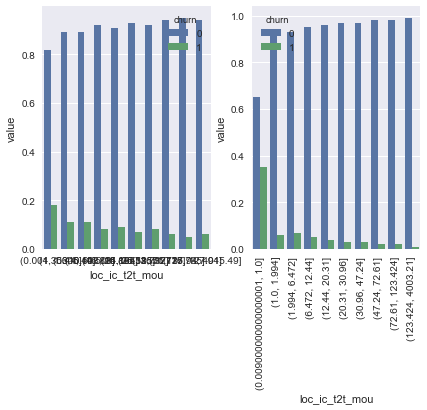

churn,0,1
std_ic_t2t_mou,,
"(0.004, 0.65]",0.91,0.09
"(0.65, 1.0]",0.92,0.08
"(1.0, 1.025]",0.91,0.09
"(1.025, 2.715]",0.90,0.10
"(2.715, 5.62]",0.91,0.09
"(5.62, 11.345]",0.90,0.10
"(11.345, 24.769]",0.90,0.10
"(24.769, 5630.245]",0.89,0.11
churn,0,1


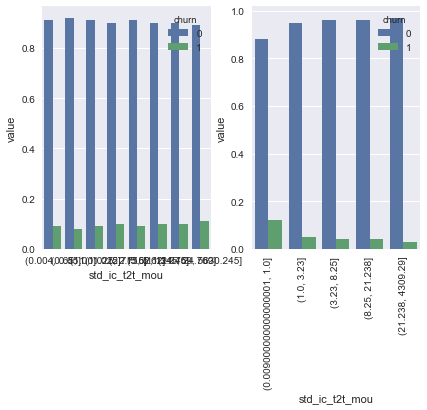

churn,0,1
max_rech_amt,,
"(0.999, 47.0]",0.91,0.09
"(47.0, 80.0]",0.88,0.12
"(80.0, 110.0]",0.89,0.11
"(110.0, 120.0]",0.92,0.08
"(120.0, 135.0]",0.90,0.10
"(135.0, 154.0]",0.96,0.04
"(154.0, 198.0]",0.93,0.07
"(198.0, 252.0]",0.94,0.06
"(252.0, 3299.0]",0.89,0.11


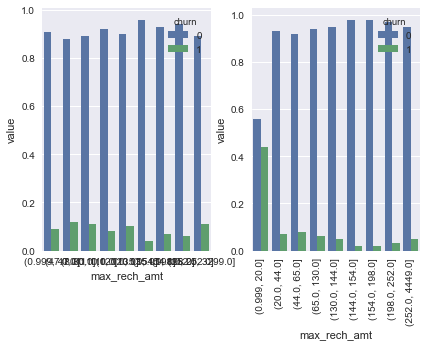

In [95]:
df_avg_6_7 = data_avg_6_7.copy(deep=True)
df_8 = data_8.copy(deep=True)
simultaneous_quant_analysis([df_avg_6_7,df_8], 'churn')

## Inference

1. Going over the side by side analysis, it is quite clear that the across different metrics, including minutes of usage, and recharge amount the churn to non-churn ratio has much more variation and in the action month i.e. August w.r.t other months.
2. As the minutes of usage and recharge amount decreases across months churn to non-churn ratio increases.

In [96]:
data.shape

(25323, 160)

In [97]:
#check the ratio metric for arpu
col = [c for c in data.columns if 'total_ic_mou' in c]
data[col].head()

,total_ic_mou_8,total_ic_mou_avg_6_7,total_ic_mou_ratio_8_to_avg_6_7
0,5.44,1.000,5.440000
8,16.54,66.175,0.249943
21,261.04,169.490,1.540150
23,298.33,171.235,1.742226
38,49.64,69.365,0.715635


### Derived Metrics

##### 1. Ratio of month 8 to average of months 6 and 7 of all variables will give us information about impending churn

In [98]:
data.columns

Index(['mobile_number', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8',
       'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8',
       ...
       'arpu_2g_avg_6_7', 'arpu_2g_ratio_8_to_avg_6_7', 'monthly_2g_avg_6_7',
       'monthly_2g_ratio_8_to_avg_6_7', 'monthly_3g_avg_6_7',
       'monthly_3g_ratio_8_to_avg_6_7', 'vbc_3g_avg_6_7',
       'vbc_3g_ratio_8_to_avg_6_7', 'total_rech_avg_6_7',
       'total_rech_ratio_8_to_avg_6_7'],
      dtype='object', length=160)

In [99]:
a2= data.groupby(['churn']).mean()

In [100]:
pd.options.display.max_columns = 250
a2

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,total_rech_8,avg_rech_amt_6_7,delta_date_last_rech_6,delta_date_last_rech_7,delta_date_last_rech_8,arpu_avg_6_7,arpu_ratio_8_to_avg_6_7,onnet_mou_avg_6_7,onnet_mou_ratio_8_to_avg_6_7,offnet_mou_avg_6_7,offnet_mou_ratio_8_to_avg_6_7,roam_ic_mou_avg_6_7,roam_ic_mou_ratio_8_to_avg_6_7,roam_og_mou_avg_6_7,roam_og_mou_ratio_8_to_avg_6_7,loc_og_t2t_mou_avg_6_7,loc_og_t2t_mou_ratio_8_to_avg_6_7,loc_og_t2m_mou_avg_6_7,loc_og_t2m_mou_ratio_8_to_avg_6_7,loc_og_t2f_mou_avg_6_7,loc_og_t2f_mou_ratio_8_to_avg_6_7,loc_og_t2c_mou_avg_6_7,loc_og_t2c_mou_ratio_8_to_avg_6_7,loc_og_mou_avg_6_7,loc_og_mou_ratio_8_to_avg_6_7,std_og_t2t_mou_avg_6_7,std_og_t2t_mou_ratio_8_to_avg_6_7,std_og_t2m_mou_avg_6_7,std_og_t2m_mou_ratio_8_to_avg_6_7,std_og_t2f_mou_avg_6_7,std_og_t2f_mou_ratio_8_to_avg_6_7,std_og_mou_avg_6_7,std_og_mou_ratio_8_to_avg_6_7,isd_og_mou_avg_6_7,isd_og_mou_ratio_8_to_avg_6_7,spl_og_mou_avg_6_7,spl_og_mou_ratio_8_to_avg_6_7,og_others_avg_6_7,og_others_ratio_8_to_avg_6_7,total_og_mou_avg_6_7,total_og_mou_ratio_8_to_avg_6_7,loc_ic_t2t_mou_avg_6_7,loc_ic_t2t_mou_ratio_8_to_avg_6_7,loc_ic_t2m_mou_avg_6_7,loc_ic_t2m_mou_ratio_8_to_avg_6_7,loc_ic_t2f_mou_avg_6_7,loc_ic_t2f_mou_ratio_8_to_avg_6_7,loc_ic_mou_avg_6_7,loc_ic_mou_ratio_8_to_avg_6_7,std_ic_t2t_mou_avg_6_7,std_ic_t2t_mou_ratio_8_to_avg_6_7,std_ic_t2m_mou_avg_6_7,std_ic_t2m_mou_ratio_8_to_avg_6_7,std_ic_t2f_mou_avg_6_7,std_ic_t2f_mou_ratio_8_to_avg_6_7,std_ic_mou_avg_6_7,std_ic_mou_ratio_8_to_avg_6_7,total_ic_mou_avg_6_7,total_ic_mou_ratio_8_to_avg_6_7,spl_ic_mou_avg_6_7,spl_ic_mou_ratio_8_to_avg_6_7,isd_ic_mou_avg_6_7,isd_ic_mou_ratio_8_to_avg_6_7,ic_others_avg_6_7,ic_others_ratio_8_to_avg_6_7,total_rech_num_avg_6_7,total_rech_num_ratio_8_to_avg_6_7,total_rech_amt_avg_6_7,total_rech_amt_ratio_8_to_avg_6_7,max_rech_amt_avg_6_7,max_rech_amt_ratio_8_to_avg_6_7,last_day_rch_amt_avg_6_7,last_day_rch_amt_ratio_8_to_avg_6_7,total_rech_data_avg_6_7,total_rech_data_ratio_8_to_avg_6_7,max_rech_data_avg_6_7,max_rech_data_ratio_8_to_avg_6_7,count_rech_2g_avg_6_7,count_rech_2g_ratio_8_to_avg_6_7,count_rech_3g_avg_6_7,count_rech_3g_ratio_8_to_avg_6_7,av_rech_amt_data_avg_6_7,av_rech_amt_data_ratio_8_to_avg_6_7,vol_2g_mb_avg_6_7,vol_2g_mb_ratio_8_to_avg_6_7,vol_3g_mb_avg_6_7,vol_3g_mb_ratio_8_to_avg_6_7,arpu_3g_avg_6_7,arpu_3g_ratio_8_to_avg_6_7,arpu_2g_avg_6_7,arpu_2g_ratio_8_to_avg_6_7,monthly_2g_avg_6_7,monthly_2g_ratio_8_to_avg_6_7,monthly_3g_avg_6_7,monthly_3g_ratio_8_to_avg_6_7,vbc_3g_avg_6_7,vbc_3g_ratio_8_to_avg_6_7,total_rech_avg_6_7,total_rech_ratio_8_to_avg_6_7
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7.001207e+09,463.408464,226.752348,321.973626,9.689143,15.819236,71.553470,145.977628,5.453820,2.346540,222.322417,149.962080,155.827370,2.081648,306.451146,2.037538,6.616774,1.032904,535.781946,57.164303,137.630397,12.806063,207.182883,10.413891,21.108524,2.530557,32.695380,248.959071,0.936174,9.044121,1.775083,10.140630,533.820087,143.990645,85.471480,1.972584,59.553597,1.817705,1.084456,95.864242,104.419104,228.143743,34.970613,33.7620

In [105]:
ratio_cols = [c for c in data.columns if '_ratio_8_to_avg_6_7' in c]
ratio_cols[0:5]

['arpu_ratio_8_to_avg_6_7',
 'onnet_mou_ratio_8_to_avg_6_7',
 'offnet_mou_ratio_8_to_avg_6_7',
 'roam_ic_mou_ratio_8_to_avg_6_7',
 'roam_og_mou_ratio_8_to_avg_6_7']

In [102]:
a2[ratio_cols]

,arpu_ratio_8_to_avg_6_7,onnet_mou_ratio_8_to_avg_6_7,offnet_mou_ratio_8_to_avg_6_7,roam_ic_mou_ratio_8_to_avg_6_7,roam_og_mou_ratio_8_to_avg_6_7,loc_og_t2t_mou_ratio_8_to_avg_6_7,loc_og_t2m_mou_ratio_8_to_avg_6_7,loc_og_t2f_mou_ratio_8_to_avg_6_7,loc_og_t2c_mou_ratio_8_to_avg_6_7,loc_og_mou_ratio_8_to_avg_6_7,std_og_t2t_mou_ratio_8_to_avg_6_7,std_og_t2m_mou_ratio_8_to_avg_6_7,std_og_t2f_mou_ratio_8_to_avg_6_7,std_og_mou_ratio_8_to_avg_6_7,isd_og_mou_ratio_8_to_avg_6_7,spl_og_mou_ratio_8_to_avg_6_7,og_others_ratio_8_to_avg_6_7,total_og_mou_ratio_8_to_avg_6_7,loc_ic_t2t_mou_ratio_8_to_avg_6_7,loc_ic_t2m_mou_ratio_8_to_avg_6_7,loc_ic_t2f_mou_ratio_8_to_avg_6_7,loc_ic_mou_ratio_8_to_avg_6_7,std_ic_t2t_mou_ratio_8_to_avg_6_7,std_ic_t2m_mou_ratio_8_to_avg_6_7,std_ic_t2f_mou_ratio_8_to_avg_6_7,std_ic_mou_ratio_8_to_avg_6_7,total_ic_mou_ratio_8_to_avg_6_7,spl_ic_mou_ratio_8_to_avg_6_7,isd_ic_mou_ratio_8_to_avg_6_7,ic_others_ratio_8_to_avg_6_7,total_rech_num_ratio_8_to_avg_6_7,total_rech_amt_ratio_8_to_avg_6_7,max_rech_amt_ratio_8_to_avg_6_7,last_day_rch_amt_ratio_8_to_avg_6_7,total_rech_data_ratio_8_to_avg_6_7,max_rech_data_ratio_8_to_avg_6_7,count_rech_2g_ratio_8_to_avg_6_7,count_rech_3g_ratio_8_to_avg_6_7,av_rech_amt_data_ratio_8_to_avg_6_7,vol_2g_mb_ratio_8_to_avg_6_7,vol_3g_mb_ratio_8_to_avg_6_7,arpu_3g_ratio_8_to_avg_6_7,arpu_2g_ratio_8_to_avg_6_7,monthly_2g_ratio_8_to_avg_6_7,monthly_3g_ratio_8_to_avg_6_7,vbc_3g_ratio_8_to_avg_6_7,total_rech_ratio_8_to_avg_6_7
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.199137,2.347362,2.121479,3.159476,4.36069,2.960602,1.903498,2.332544,4.235474,1.902874,2.542022,2.916203,1.653738,2.992777,1.825342,5.648495,1.481618,2.542130,2.327557,1.572813,2.629265,1.470186,3.588392,5.631784,2.532456,3.296732,1.610578,3.304627,3.963088,3.671125,0.895797,1.161933,1.179067,6.523749,1.210127,4.107268,1.218786,1.158482,5.378477,15.911331,20.823325,24.954199,27.024464,1.109309,1.088914,9.465215,0.982971
1,0.433212,0.742368,0.771152,6.543050,10.68526,0.856161,0.857548,1.535630,3.253169,0.857823,1.082629,0.991829,1.258805,1.400399,2.144319,3.526398,1.358933,0.948464,0.876363,1.154723,1.764267,1.400553,2.240347,1.745211,1.478475,1.529897,0.720381,3.458285,2.494006,2.882475,0.476508,0.474141,0.657507,2.719475,0.984071,1.791042,1.009608,1.104394,2.087500,2.759672,3.446660,4.781956,4.550124,1.075425,1.073673,4.544309,0.299635


The stark difference in the average of the ratio variables between churn and non-churn means they are likely to be useful to the model

Hypothesis: People who are likely to move or have moved are likely to attrite- Can be measured by creating ratio of Roam to (Local + Std) 

##### 2. Roaming Outgoing as a ratio of (Local +STD) in August to the Average of same variable for June and July

In [103]:
data['roam_ratio_og_8'] = data['roam_og_mou_8'] / (data['loc_og_mou_8'] + data['std_og_mou_8'])
data['roam_ratio_avg_6_7'] = data['roam_og_mou_avg_6_7'] / (data['loc_og_mou_avg_6_7'] + data['std_og_mou_avg_6_7'])
data['roam_ratio_og'] = (data['roam_ratio_og_8']) / (data['roam_ratio_avg_6_7'])


In [75]:
a2= data.groupby(['churn']).mean()
a2[['roam_ratio_og_8', 'roam_ratio_avg_6_7','roam_ratio_og']]

,roam_ratio_og_8,roam_ratio_avg_6_7,roam_ratio_og
churn,,,
0,1.243948,0.641821,65.768160
1,12.641728,7.389012,686.523745


As one can see, the roam ratio as you can see is highly signficantly different between churn and non churn

#### 3. Ratio of Outgoing to Incoming

In [76]:
data['og_ic_avg_6_7'] = data['total_og_mou_avg_6_7'] / data['total_ic_mou_avg_6_7']
data['og_ic_8'] = data['total_og_mou_8'] / data['total_ic_mou_8']

data['og_ic_ratio'] = (data['og_ic_8'])/ (data['og_ic_avg_6_7'])

In [77]:
a2= data.groupby(['churn']).mean()
a2[['og_ic_ratio']]

,og_ic_ratio
churn,
0,2.005999
1,2.852990


As expected, there is a reduction in the ratio of Outgoing to Incoming from Non Churn to Churn. This variable could come in handy while building the model. 

# 4. Model Creation- Preparing the Dataset

In [78]:
# Create the Feature(x) and Response(y) datasets

x = data.drop(['mobile_number','churn'], axis=1)
x=(x-x.mean())/x.std()

y = data['churn']


In [79]:
# Splitting the data into Test and Train

from sklearn.model_selection import train_test_split
x_train, x_test, y_train,  y_test = train_test_split(x, y, train_size = 0.7, test_size = 0.3, random_state=100)


In [80]:
# % of Churn vs non Churn
y_train.value_counts()*100/len(y_train)

0    91.114747
1    8.885253 
Name: churn, dtype: float64

####  Inference : As the % of churn is very low compared to non churns lets apply a Sampling Technique to maintain the balance.
#### We will use a SMOTE: Synthetic Minority Over-sampling Technique

### Oversampling using SMOTE 

In [81]:
# Apply SMOTE to increase the minority class to 33%

from imblearn.over_sampling import SMOTE 

sm = SMOTE(ratio = 0.5,random_state=100)
x_res, y_res = sm.fit_sample(x_train, y_train)


# Checking the Churn % after SMOTE
pd.Series(y_res).value_counts()*100/len(pd.Series(y_res))

/Users/Snehit/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


0    66.668043
1    33.331957
dtype: float64

### Creating the functions to construct the models

In [82]:
from sklearn import metrics 

def generate_roc_auc_curve(y_test,pred_probs_test):
    fpr, tpr, threshold  = metrics.roc_curve(y_test, pred_probs_test)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [83]:
def measure_accuracy(test_y, predictions):
    """ 
    Function that takes in the predictions and labels of test dataset to determine the F-1 score,
    sensitivity, specificity, recall and precision for the given dataset.

    @Author Aryan Singh
    """    
    confusion = metrics.confusion_matrix(test_y, predictions)

    TP = confusion[1,1]
    TN = confusion[0,0]
    FP = confusion[0,1]
    FN = confusion[1,0]
    
    print("Accuracy Score", metrics.accuracy_score(test_y, predictions))
    
    print("\nConfusion Matrix \n")
    sb.heatmap(confusion, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.show()
    sensitivity = TP/ (TP + FN)
    print("Sensitivity ", sensitivity)

    specificity = TN/(TN + FP)
    print("Specificity", specificity)

    precision = TP / (TP + FP)
    print("Precision Score:",metrics.precision_score(test_y, predictions))

    print("Recall Score:", metrics.recall_score(test_y, predictions))

    print("F1 Score:", metrics.f1_score(test_y, predictions))
    
    generate_roc_auc_curve(test_y, predictions)

def train_model(clf, train_x,train_y,test_x,test_y):
    """ 
    Function that trains the given classifier on training data and comes up with prediction and accuracy score
    for the test dataset

    @Author Aryan Singh
    """
    print("##########################" + clf.__class__.__name__ + "##########################")
    trained_model = clf.fit(train_x, train_y)
    print(trained_model)
    predictions_train = trained_model.predict(train_x)
    predictions = trained_model.predict(test_x)
    measure_accuracy(test_y, predictions)    

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def tune_hyperparameters(clf, parameters, score, X_train, y_train, cv=5):
    """ 
    Function that takes in the classifier, parameter dictionary and the dataset and returns the best 
    classifier on the basis of the scorer method provided.
    
    -> score: The scoring function could be f1_score, accuracy etc.
    -> parameters: dictionary of parameters for the grid search
    -> Number of Cross Validations to be performed, default 5
    
    @Author Aryan Singh
    """
    scorer = make_scorer(score)
    grid_obj = GridSearchCV(clf,scoring=scorer,param_grid=parameters,cv=cv)
    grid_obj = grid_obj.fit(X_train,y_train)
    clf = grid_obj.best_estimator_
    print("Best Estimator is following\n")
    print(clf)
    return clf

# 5. Models: Prediction Models

### PCA

In [85]:
# Number of dependent variables

x_res.shape

(24226, 164)

#### As number of independent variables is quite high, lets reduce the dimensionality using PCA.
#### We will capture 95% of the variance.

In [86]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pca = PCA(0.95)
df_train_pca = pca.fit_transform(x_res)

# New number of column after PCA
df_train_pca.shape

(24226, 93)

#### PCA reduces the dimensionality to 56 columns.

In [87]:
df_test_pca = pca.transform(x_test)

#### Now that we have applied PCA, lets create few models on this dataset and then choose the best. We will create the following models.

1. Logistic Regression
2. SVM
3. Naive Bayes

#### Models with Hyperparameter Tuning

In [88]:
def measure_accuracy(clf, x_test, y_test):
    """ 
    Function that takes in the predictions and labels of test dataset to determine the F-1 score,
    sensitivity, specificity, recall and precision for the given dataset.

    @Author Aryan Singh
    """    
    print("--------------------------------")
    y_pred_1 = clf.predict_proba(x_test)
    y_pred_2 = pd.DataFrame(y_pred_1).iloc[:,[1]]
    predictions = y_pred_2.iloc[:,0].map(lambda x: 1 if x > .5 else 0)
    confusion = metrics.confusion_matrix(y_test, predictions)

    TP = confusion[1,1]
    TN = confusion[0,0]
    FP = confusion[0,1]
    FN = confusion[1,0]
    
    print("Accuracy Score", metrics.accuracy_score(y_test, predictions))
    
    print("\nConfusion Matrix \n")
    sb.heatmap(confusion, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.show()
    sensitivity = TP/ (TP + FN)
    print("Sensitivity ", sensitivity)

    specificity = TN/(TN + FP)
    print("Specificity", specificity)

    precision = TP / (TP + FP)
    
    print("F1 Score:", metrics.f1_score(y_test, predictions))
    
    


In [89]:
def roc_curve(clf, x_test, y_test):
    print("--------------------------------")
    y_pred_1 = clf.predict_proba(x_test)
    y_pred_2 = pd.DataFrame(y_pred_1).iloc[:,[1]]
    y_pred = y_pred_2.iloc[:,0].map(lambda x: 1 if x > .5 else 0)
    fpr, tpr, threshold  = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('ROC AUC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [90]:

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training , y_train)data. '''
    clf.fit(X_train, y_train)

def predict_labels(clf, features, target):
    y_pred = clf.predict(features)
    
    return round(metrics.roc_auc_score( target, y_pred),2), round(accuracy_score(target, y_pred),2), round(precision_score(target, y_pred),2), round(recall_score(target, y_pred),2)
    
def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of. . .",clf.__class__.__name__,len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    auc, acc, precision, recall = predict_labels(clf, X_train, y_train)
    print("--------------------------------")
    print("AUC score for training set:",auc)
    print("Accuracyfor training set:",acc)
    print("Precision score for training set:",precision)
    print("Recall score for training set:",recall)
    
    auc, acc, precision, recall = predict_labels(clf, X_test, y_test)
    print("--------------------------------")
    print("AUC score for test set:",auc)
    print("Accuracyfor test set:",acc)
    print("Precision score for test set:",precision)
    print("Recall score for test set:",recall)
    measure_accuracy(clf, X_test, y_test)
    roc_curve(clf, X_test, y_test)

#### 1. Logistic Regression

In [91]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'penalty': ['l1', 'l2'], 
                  'C': [0.1, 1, 10, 100, 1000]}]


# specify model
model = LogisticRegression()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(df_train_pca, y_res)  

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [92]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9197111439667143 corresponding to hyperparameters {'C': 10, 'penalty': 'l2'}


#### Logistic Regression model with best hyperparameters

Training a {} using a training set size of. . . LogisticRegression 24226
--------------------------------
AUC score for training set: 0.85
Accuracyfor training set: 0.87
Precision score for training set: 0.81
Recall score for training set: 0.8
--------------------------------
AUC score for test set: 0.83
Accuracyfor test set: 0.89
Precision score for test set: 0.43
Recall score for test set: 0.75
--------------------------------
Accuracy Score 0.890877978149

Confusion Matrix 



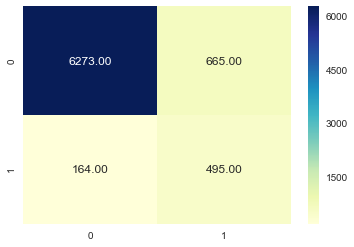

Sensitivity  0.751138088012
Specificity 0.904151052176
F1 Score: 0.544255085212
--------------------------------


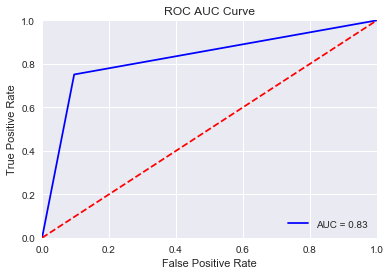

In [93]:
clf_best_LR = LogisticRegression(C=100, penalty='l2')

train_predict(clf_best_LR, df_train_pca, y_res, df_test_pca, y_test)
print('')

#### 2. SVM

In [123]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 2, shuffle = True, random_state = 4)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.01, 0.001, 0.1],
                     'C': [100]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(df_train_pca, y_res)  

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.0min finished


GridSearchCV(cv=KFold(n_splits=2, random_state=4, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'gamma': [0.01, 0.001, 0.1], 'C': [100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [124]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9839170608086751 corresponding to hyperparameters {'C': 100, 'gamma': 0.1}


#### SVM model with best hyperparameters

Training a {} using a training set size of. . . SVC 24226
--------------------------------
AUC score for training set: 0.99
Accuracyfor training set: 0.99
Precision score for training set: 0.98
Recall score for training set: 1.0
--------------------------------
AUC score for test set: 0.73
Accuracyfor test set: 0.91
Precision score for test set: 0.48
Recall score for test set: 0.52
--------------------------------
Accuracy Score 0.9160194813742266

Confusion Matrix 



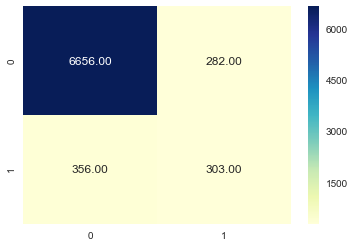

Sensitivity  0.4597875569044006
Specificity 0.9593542807725569
F1 Score: 0.4871382636655948
--------------------------------


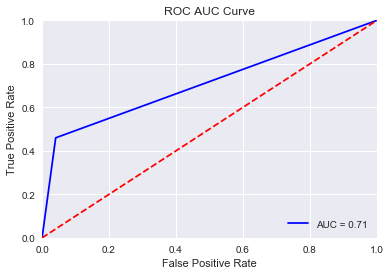

In [121]:
clf_best_SVC = SVC(C=100, gamma=0.01, probability=True)

train_predict(clf_best_SVC, df_train_pca, y_res, df_test_pca, y_test)
print('')

#### 3. Naive Bayes

Training a {} using a training set size of. . . GaussianNB 24226
--------------------------------
AUC score for training set: 0.57
Accuracyfor training set: 0.46
Precision score for training set: 0.37
Recall score for training set: 0.89
--------------------------------
AUC score for test set: 0.55
Accuracyfor test set: 0.3
Precision score for test set: 0.1
Recall score for test set: 0.86
--------------------------------
Accuracy Score 0.29946031328155853

Confusion Matrix 



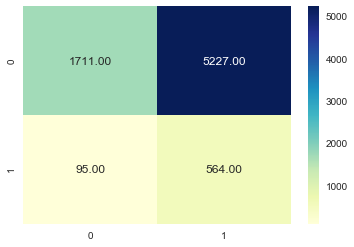

Sensitivity  0.8558421851289834
Specificity 0.2466128567310464
F1 Score: 0.17488372093023255
--------------------------------


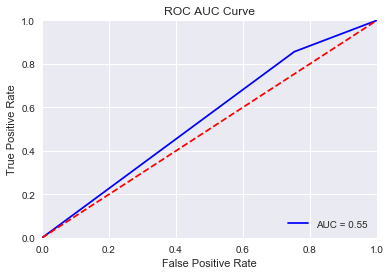

In [122]:
mnb = GaussianNB()

train_predict(mnb, df_train_pca, y_res, df_test_pca, y_test)
print('')

## Prediction Models Conclusion : Best model for the dataset with PCA :
### Logistic Regression with hyperparameters {'C': 100, 'penalty': 'l2'}


Training a {} using a training set size of. . . LogisticRegression 24226
--------------------------------
AUC score for training set: 0.85
Accuracyfor training set: 0.87
Precision score for training set: 0.81
Recall score for training set: 0.8
--------------------------------
AUC score for test set: 0.83
Accuracyfor test set: 0.89
Precision score for test set: 0.43
Recall score for test set: 0.75
--------------------------------
Accuracy Score 0.8914045017770172

Confusion Matrix 



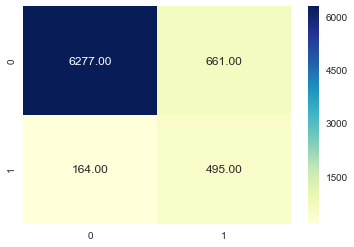

Sensitivity  0.7511380880121397
Specificity 0.9047275872009225
F1 Score: 0.5454545454545454
--------------------------------


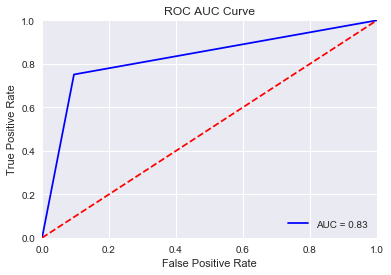

In [127]:
train_predict(clf_best_LR, df_train_pca, y_res, df_test_pca, y_test)
print('')

# 6. Models- Driver Variables Models

1. Decision Tree using Grid Search Cross Validation
2. Random Forest 

In [142]:
data.drop(get_correlated_columns_cut_off(data, 0.70), axis=1, inplace=True)

In [95]:
# Create the Feature(x) and Response(y) datasets

x = data.drop(['mobile_number','churn'], axis=1)
#x=(x-x.mean())/x.std()

y = data['churn']


In [96]:
# Splitting the data into Test and Train

from sklearn.model_selection import train_test_split
x_train, x_test, y_train,  y_test = train_test_split(x, y, train_size = 0.7, test_size = 0.3, random_state=100)


In [97]:
# % of Churn vs non Churn
y_train.value_counts()*100/len(y_train)

0    91.114747
1    8.885253 
Name: churn, dtype: float64

####  Inference : As the % of churn is very low compared to non churns lets apply a Sampling Technique to maintain the balance.
#### We will use a SMOTE: Synthetic Minority Over-sampling Technique

### Oversampling using SMOTE 

In [98]:
# Apply SMOTE to increase the minority class to 33%

from imblearn.over_sampling import SMOTE 

sm = SMOTE(ratio = 0.5,random_state=100)
x_res, y_res = sm.fit_sample(x_train, y_train)


# Checking the Churn % after SMOTE
pd.Series(y_res).value_counts()*100/len(pd.Series(y_res))

/Users/Snehit/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


0    66.668043
1    33.331957
dtype: float64

### 1. Decision Tree training using Grid Search CV

In [99]:
# Create the parameter grid 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(x_res,y_res)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(5, 15, 5), 'min_samples_leaf': range(50, 150, 50), 'min_samples_split': range(50, 150, 50), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [101]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.899116651531
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### Use the paramters from the above result (entropy, max depth 10, min samples in leaf 50 and min samples split 50)

In [102]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "entropy", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)
clf_gini.fit(x_res, y_res)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [103]:
# accuracy score
clf_gini.score(x_test,y_test)

0.91299197051467684

In [104]:
# If you're on windows:
# Specifing path for dot file.
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot, graphviz


In [105]:
features = list(x.columns)

In [106]:
# plotting the tree
#dot_data = StringIO()  
#export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

#graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#Image(graph[0].create_png())
#graph[0].write_pdf("telecom_churn.pdf")

#### Lets look at the accuracy, specificity, etc metrics.

In [107]:
# classification metrics
from sklearn.metrics import classification_report,confusion_matrix
y_pred = clf_gini.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.93      0.95      6938
          1       0.50      0.71      0.59       659

avg / total       0.93      0.91      0.92      7597



In [108]:
print(confusion_matrix(y_test,y_pred))

[[6467  471]
 [ 190  469]]


In [109]:
# printing the optimal accuracy score and hyperparameters
matrix = confusion_matrix(y_test,y_pred)
tn = matrix[0][0]
tp = matrix[1][1]
fn = matrix[1][0]
fp = matrix[0][1]
print('False negative rate: ',fn*100/ (fn + tp))
print('Sensitivity        : ',tp*100/ (tp + fn))
print('Specificity        : ',tn*100/ (tn + fp))

False negative rate:  28.8315629742
Sensitivity        :  71.1684370258
Specificity        :  93.2113000865


In [110]:
for feature in sorted(zip(x.columns, clf_gini.feature_importances_), key=lambda x: x[1], reverse=True):
        print(feature)

('loc_ic_mou_8', 0.39384754824839185)
('roam_ratio_og', 0.14767289313488241)
('fb_user_8', 0.11078005283676402)
('delta_date_last_rech_8', 0.072068858669704319)
('last_day_rch_amt_8', 0.034808353364758932)
('roam_og_mou_8', 0.028391467116966954)
('roam_ratio_og_8', 0.025833599310278732)
('roam_og_mou_ratio_8_to_avg_6_7', 0.01434897020930186)
('total_ic_mou_ratio_8_to_avg_6_7', 0.012833347375246112)
('og_ic_ratio', 0.012466735379791859)
('fb_user_7', 0.011803401006954787)
('og_ic_8', 0.01133240909256992)
('av_rech_amt_data_8', 0.010261960083798281)
('total_rech_num_8', 0.0098956936090285798)
('spl_og_mou_avg_6_7', 0.0078063787851749434)
('total_rech_amt_ratio_8_to_avg_6_7', 0.0069913668139515318)
('loc_ic_mou_ratio_8_to_avg_6_7', 0.0053077101433044458)
('aon', 0.0047156902686958328)
('roam_og_mou_avg_6_7', 0.0045052237557654199)
('std_og_t2t_mou_avg_6_7', 0.0040612980053512399)
('total_rech_num_avg_6_7', 0.0039204166638030658)
('sachet_3g_7', 0.0038592508306422363)
('total_rech_ratio_8_

In [111]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [112]:
# fit
rfc.fit(x_res,y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [113]:
# Making predictions
predictions = rfc.predict(x_test)

In [114]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [115]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96      6938
          1       0.62      0.61      0.62       659

avg / total       0.93      0.93      0.93      7597



In [116]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[6693  245]
 [ 256  403]]


In [117]:
# printing the optimal accuracy score and hyperparameters
matrix = confusion_matrix(y_test,predictions)
tn = matrix[0][0]
tp = matrix[1][1]
fn = matrix[1][0]
fp = matrix[0][1]
print('False negative rate: ',fn*100/ (fn + tp))
print('Sensitivity        : ',tp*100/ (tp + fn))
print('Specificity        : ',tn*100/ (tn + fp))

False negative rate:  38.846737481
Sensitivity        :  61.153262519
Specificity        :  96.4687229749


In [118]:
print(accuracy_score(y_test,predictions))

0.934052915625


### 2. Random forest classifier with Grid Search CV

In [119]:
# Create the parameter grid based on the results of random search 
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(100, 500, 100),
    'criterion': ["entropy", "gini"],
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [120]:
# Fit the grid search to the data
grid_search.fit(x_res, y_res)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   36.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 8, 10], 'min_samples_leaf': range(100, 400, 200), 'min_samples_split': range(100, 500, 100), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [121]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.895236522744 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 100}


In [122]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             criterion='entropy',
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=100)

In [123]:
# fit
rfc.fit(x_res,y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [124]:
# predict
predictions = rfc.predict(x_test) 

In [125]:
from sklearn.metrics import classification_report,confusion_matrix

In [126]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.97      0.94      0.96      6938
          1       0.53      0.72      0.61       659

avg / total       0.93      0.92      0.93      7597



In [127]:
print(confusion_matrix(y_test,predictions))

[[6517  421]
 [ 182  477]]


### Primary goal is to NOT miss the customers that have churned. This means we want to have a LOW False negative rate.

In [128]:
# printing the optimal accuracy score and hyperparameters
matrix = confusion_matrix(y_test,predictions)
tn = matrix[0][0]
tp = matrix[1][1]
fn = matrix[1][0]
fp = matrix[0][1]
print('False negative rate: ',fn*100/ (fn + tp))
print('Sensitivity        : ',tp*100/ (tp + fn))
print('Specificity        : ',tn*100/ (tn + fp))

False negative rate:  27.6176024279
Sensitivity        :  72.3823975721
Specificity        :  93.9319688671


In [129]:
for feature in sorted(zip(x.columns, rfc.feature_importances_), key=lambda z: z[1], reverse=True):
        print(feature)

('roam_ratio_og_8', 0.071199315760070186)
('roam_ratio_og', 0.068158855926636203)
('loc_ic_mou_ratio_8_to_avg_6_7', 0.060677393559488632)
('loc_ic_t2m_mou_ratio_8_to_avg_6_7', 0.05282490854429147)
('total_rech_ratio_8_to_avg_6_7', 0.051033751654021034)
('loc_og_mou_8', 0.050190372680411231)
('total_rech_amt_8', 0.042566725746036364)
('delta_date_last_rech_8', 0.0359408097167183)
('total_rech_8', 0.035757952221656328)
('roam_ic_mou_8', 0.035721130338266037)
('fb_user_8', 0.032701304095876599)
('loc_ic_t2m_mou_8', 0.030373253483908524)
('roam_og_mou_ratio_8_to_avg_6_7', 0.030122025879423826)
('loc_ic_mou_8', 0.025285011562763131)
('loc_ic_t2t_mou_ratio_8_to_avg_6_7', 0.023156548273082271)
('offnet_mou_8', 0.019665449657154783)
('roam_og_mou_8', 0.018802430207644015)
('total_rech_amt_ratio_8_to_avg_6_7', 0.018149589613618587)
('og_ic_8', 0.016771477058749852)
('av_rech_amt_data_8', 0.016476832520373286)
('vol_2g_mb_8', 0.01562576427145522)
('total_ic_mou_ratio_8_to_avg_6_7', 0.01533990187

### Inference from Random Forest GSCV model:

Most important drivers are:
(a) Ratio of month 8 to avg of months 6&7 of 'arpu', 'total recharge amount', 'total incoming mou', 'roaming outgoing mou'
(b) Roam ratio


In [130]:
from sklearn.feature_selection import SelectFromModel

### Try modeling with features that have importance >= 0.01

In [131]:
sfm = SelectFromModel(rfc, threshold=0.009)

In [132]:
sfm.fit(x_res, y_res)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        norm_order=1, prefit=False, threshold=0.009)

In [133]:
x_important_res = sfm.transform(x_res)
x_important_test = sfm.transform(x_test)

In [134]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(bootstrap=True,
                             max_depth=8,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             n_estimators=500)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(x_important_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [135]:
# predict
predictions = clf_important.predict(x_important_test)

In [136]:
from sklearn.metrics import classification_report,confusion_matrix

In [137]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.98      0.94      0.96      6938
          1       0.53      0.75      0.62       659

avg / total       0.94      0.92      0.93      7597



In [138]:
print(confusion_matrix(y_test,predictions))

[[6505  433]
 [ 165  494]]


In [139]:
# printing the optimal accuracy score and hyperparameters
matrix = confusion_matrix(y_test,predictions)
tn = matrix[0][0]
tp = matrix[1][1]
fn = matrix[1][0]
fp = matrix[0][1]
print('False negative rate: ',fn*100/ (fn + tp))
print('Sensitivity        : ',tp*100/ (tp + fn))
print('Specificity        : ',tn*100/ (tn + fp))

False negative rate:  25.0379362671
Sensitivity        :  74.9620637329
Specificity        :  93.7590083598


In [140]:
import  matplotlib.pyplot as plt
def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
    plt.figure(figsize=(14,8))
    plt.xlabel('feature_importance')
    results = pd.Series(feature_dict)
    results.sort_values(inplace=True)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))

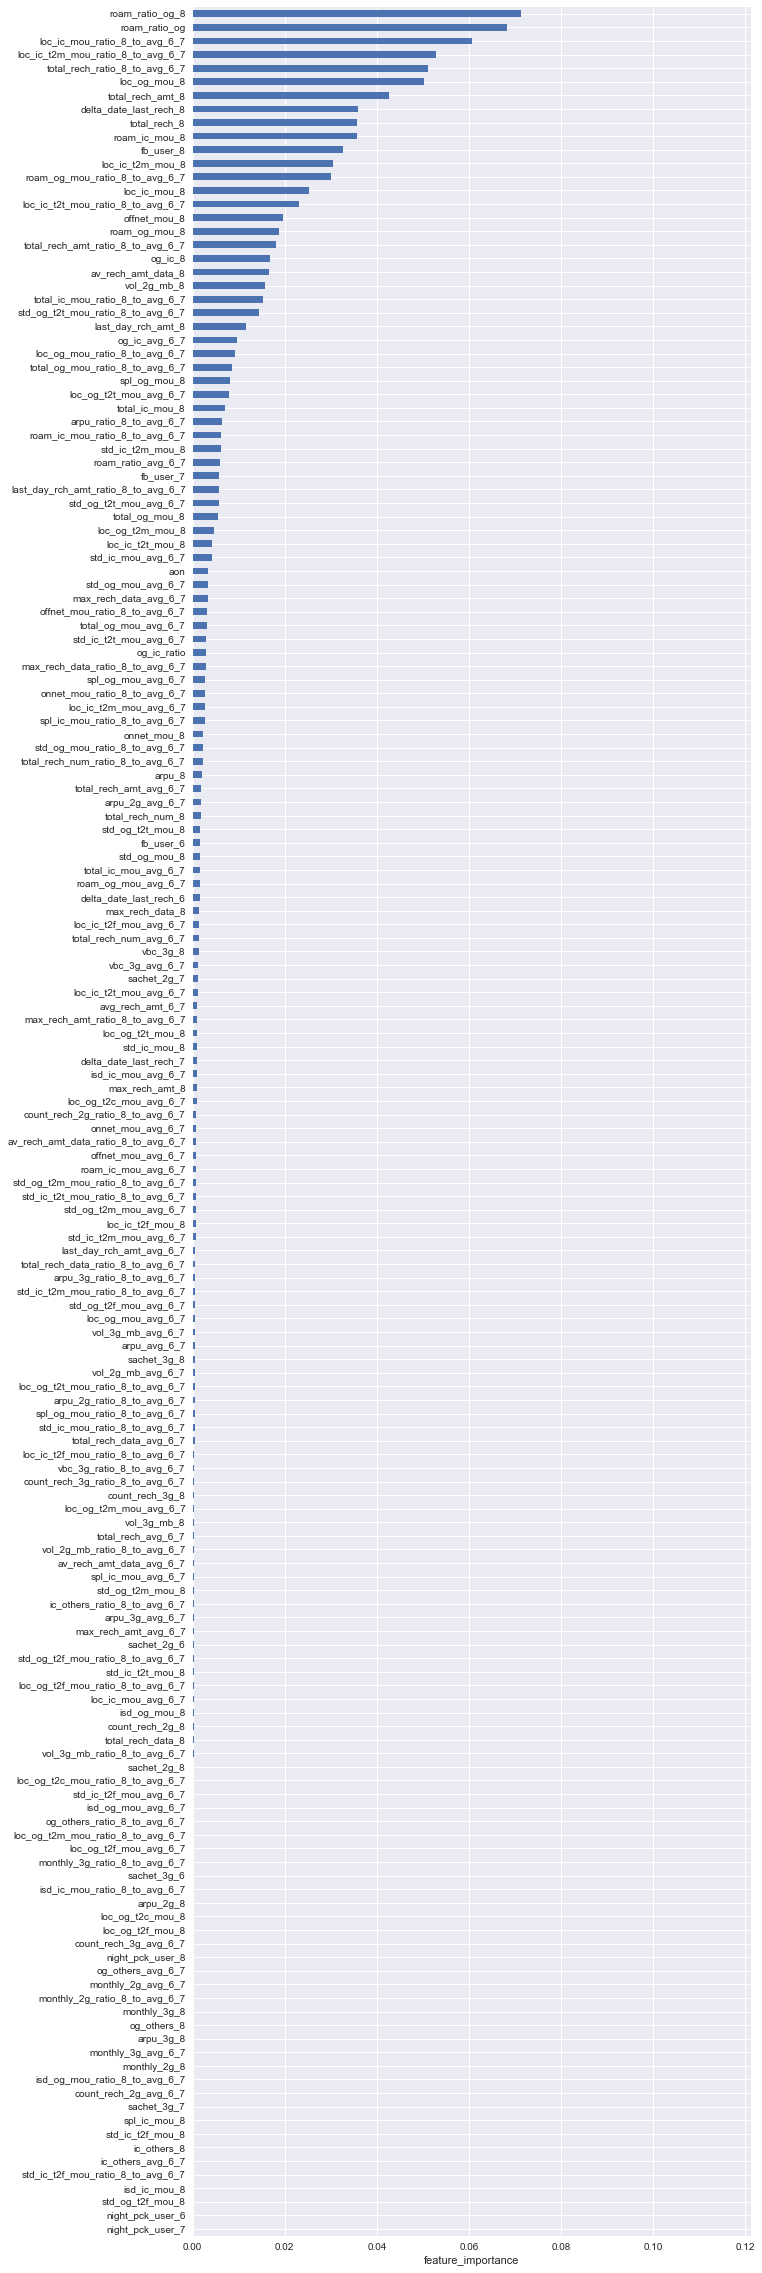

In [141]:
graph_feature_importances(rfc, x_train.columns)

In [189]:
# Top Variables by feature importance ( Not ordered)
x_train.columns[sfm.get_support()]

Index(['offnet_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'total_rech_num_8',
       'max_rech_data_8', 'delta_date_last_rech_8', 'arpu_ratio_8_to_avg_6_7',
       'roam_ic_mou_ratio_8_to_avg_6_7', 'roam_og_mou_ratio_8_to_avg_6_7',
       'std_og_t2m_mou_ratio_8_to_avg_6_7', 'total_og_mou_ratio_8_to_avg_6_7',
       'loc_ic_t2m_mou_ratio_8_to_avg_6_7', 'total_ic_mou_ratio_8_to_avg_6_7',
       'total_rech_num_ratio_8_to_avg_6_7',
       'total_rech_amt_ratio_8_to_avg_6_7',
       'last_day_rch_amt_ratio_8_to_avg_6_7', 'roam_ratio_og_8',
       'roam_ratio_avg_6_7', 'roam_ratio_og', 'og_ic_8'],
      dtype='object')

Inference:

The Random Forest Model built above has the following advantages over the decision tree- 

1. Sensitivity is higher
2. False Negative Rate is Lower.

# 7. Recommendations

With support from EDA ( Recharge spending, MOU etc which are evidently lower in month 8 for customers who churn ), the following recommendations can be made ( With these recommendations we try and cover all types of levers )

1. The ratio of offnet MOU between action and good months is the biggest driver of churn. Higher charges for offnet usage could trigger churn which should be dealt with.
2. The ratio in the recharge amount between action and good months is one of the strongest drivers of churn. Reduction in the recharge amount can be followed by an incentive to recharge.
3. The ratio in the incoming call MOU between action and good months is another of the strongest drivers of churn. Reduction in Incoming calls could indicate issues with network. Looking into this can help. 

4. The ratio of total outgoing between action and good months is a top 5 driver. As EDA shows, the total outgoing drops drastically in Action month ( by more than 60% ) which is a clear indication of impending churn. 
5. The ARPU Ratio between action and good months is a top 10 driver. As EDA shows, ARPU drops significantly in Action month which reiterates the possibilities of impending churn. 
6. The ratio of total number of recharges between action and good months is a top 15 driver. The total number of recharges comes down by 50% in Action month.
7. The ratio of roaming outgoing to (local + std) outgoing in Action Month is a top 15 driver, expectedly as this ratio increases in Action Month compared to Good Months. This is an indication that the customer has moved geographically and is on roaming and is likely to churn. A service call by the operator to the customer may help stop the churn. 
8. The delta last date of recharge in Action Month is a moderate driver. Higher this variable means longer it has been since the last recharge which could indicate impending churn. 

   For points 4 to 8, a service call to the customer enquiring the reason for reduction in patronage could help.